# Diabetes Logistic Regression Modeling

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import yellowbrick

#sn.set(rc={'figure.figsize':(10,5)})

In [2]:
data = pd.read_csv('total_cleaned.csv')
data.head

<bound method NDFrame.head of         DIABETE3  _BMI5  SMOKE100  CVDSTRK3  _TOTINDA  HLTHPLN1  MEDCOST  \
0            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
1            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
2            0.0   35.0       1.0       0.0       0.0       1.0      1.0   
3            1.0   43.0       1.0       0.0       1.0       1.0      0.0   
4            0.0   22.0       0.0       0.0       1.0       0.0      1.0   
...          ...    ...       ...       ...       ...       ...      ...   
528789       0.0   27.0       0.0       0.0       0.0       1.0      1.0   
528790       2.0   25.0       0.0       0.0       0.0       1.0      0.0   
528791       0.0   23.0       0.0       1.0       0.0       1.0      1.0   
528792       0.0   42.0       0.0       0.0       1.0       1.0      0.0   
528793       0.0   45.0       0.0       0.0       0.0       1.0      0.0   

        GENHLTH  MENTHLTH  PHYSHLTH  SEX  _AGEG5YR  EDUCA

In [3]:
data = data.rename(
    columns = 
    {'DIABETE3':'Diabetes_012',
     '_BMI5':'BMI',
     'SMOKE100':'Smoker',
     'CVDSTRK3':'Stroke',
     '_TOTINDA':'PhysActivity',
     'HLTHPLN1':'AnyHealthcare',
     'MEDCOST':'NoDocbcCost',
     'GENHLTH':'GenHlth',
     'MENTHLTH':'MentHlth',
     'PHYSHLTH':'PhysHlth',
     'SEX':'Sex',
     '_AGE5YR':'Age',
     'EDUCA':'Education',
     'INCOME2':'Income',
     'MARITAL':'Marital',
     'POORHLTH':'PoorHlth',
     'CVDINFR4':'HeartAttack',
     '_RFHYPE5':'HighBP',
     '_AGEG5YR':'Age'
    }
)

In [4]:
data.isna().sum()

Diabetes_012     0
BMI              0
Smoker           0
Stroke           0
PhysActivity     0
AnyHealthcare    0
NoDocbcCost      0
GenHlth          0
MentHlth         0
PhysHlth         0
Sex              0
Age              0
Education        0
Income           0
Marital          0
PoorHlth         0
HeartAttack      0
HighBP           0
dtype: int64

In [5]:
data.dtypes

Diabetes_012     float64
BMI              float64
Smoker           float64
Stroke           float64
PhysActivity     float64
AnyHealthcare    float64
NoDocbcCost      float64
GenHlth          float64
MentHlth         float64
PhysHlth         float64
Sex              float64
Age              float64
Education        float64
Income           float64
Marital          float64
PoorHlth         float64
HeartAttack      float64
HighBP           float64
dtype: object

## Variable of Interest

<AxesSubplot: >

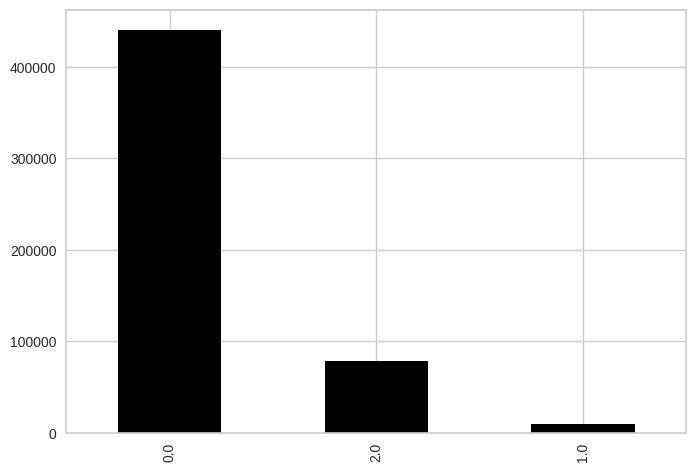

In [6]:
data['Diabetes_012'].value_counts().plot(kind='bar', color='black')

## Balancing the Dataset for Prediabetes Logistic Regression

We can see that we have quite an unbalanced dataset, with only a small proportion of our respondents in the prediabetes category. In order to perform logistic regression meaningfully, we will select a random sample of our healthy sample to compare against our prediabetes class.

In [7]:
data.groupby(['Diabetes_012']).size()

Diabetes_012
0.0    440607
1.0      9930
2.0     78257
dtype: int64

In [8]:
# select 12328 samples from healthy population
# remove diabetes class entirely


data['Diabetes_012'] = data['Diabetes_012'].replace({2:1, 1:5})

data = data[(data.Diabetes_012 != 5)]


diab = data[(data.Diabetes_012 == 1)]
nodiab = data[(data.Diabetes_012 == 0)]

data_balanced = nodiab.take(np.random.permutation(len(nodiab))[:78257])
data = data_balanced.append(diab, ignore_index=True)

data.groupby(['Diabetes_012']).size()

/tmp/ipykernel_1547/672942483.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_balanced.append(diab, ignore_index=True)


Diabetes_012
0.0    78257
1.0    78257
dtype: int64

Now we have a balanced (albeit smaller) dataset to work with, which will help for our modeling.

## Continuous Numerical Predictors

We have 1 continuous numerical predictor - BMI. 

### BMI

<AxesSubplot: title={'center': 'BMI'}, ylabel='Frequency'>

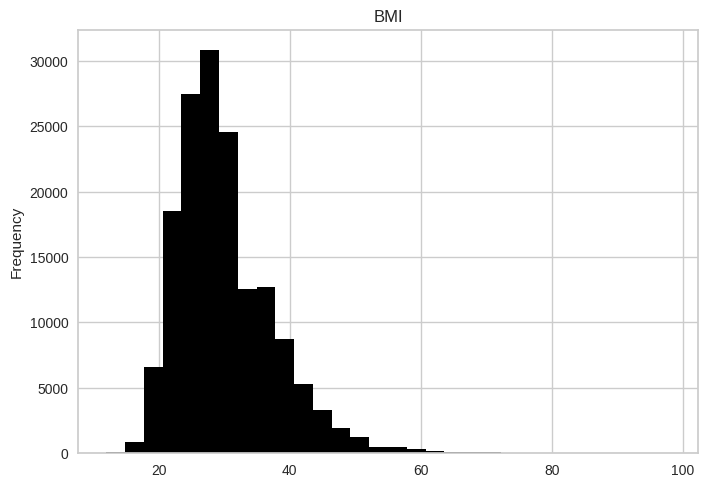

In [9]:
data['BMI'].plot(kind='hist', color='black',bins=30, title='BMI')

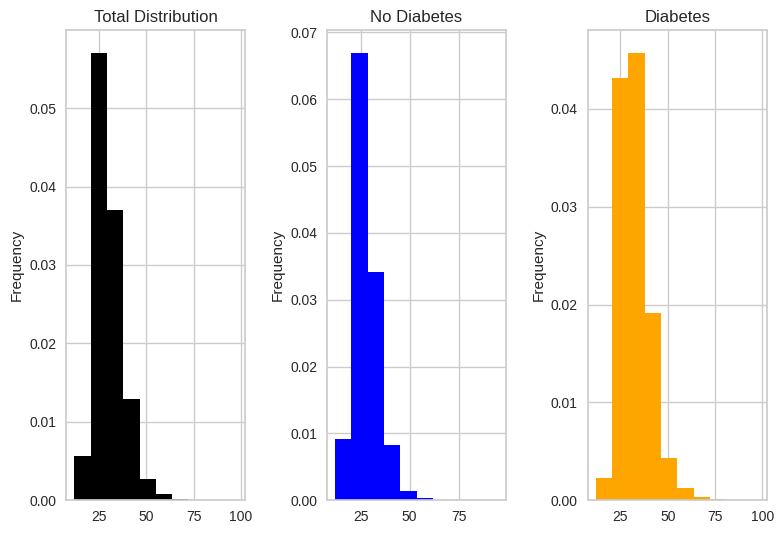

In [11]:
var = 'BMI'

fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Diabetes")
plt.tight_layout()

In [12]:
data[var].groupby(data['Diabetes_012']).describe()

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,,,,,,,,
0.0,78257.0,27.722095,6.327727,12.0,23.0,27.0,31.0,95.0
1.0,78257.0,32.522254,7.780586,12.0,27.0,31.0,37.0,98.0


In [14]:
# One-Way ANOVA - Test of Variance Between Groups
nodiab = data.query('Diabetes_012 == 0')[var]
diab = data.query('Diabetes_012 == 1')[var]

stats.f_oneway(nodiab, diab)

F_onewayResult(statistic=17928.04406728437, pvalue=0.0)

<AxesSubplot: xlabel='Diabetes_012', ylabel='BMI'>

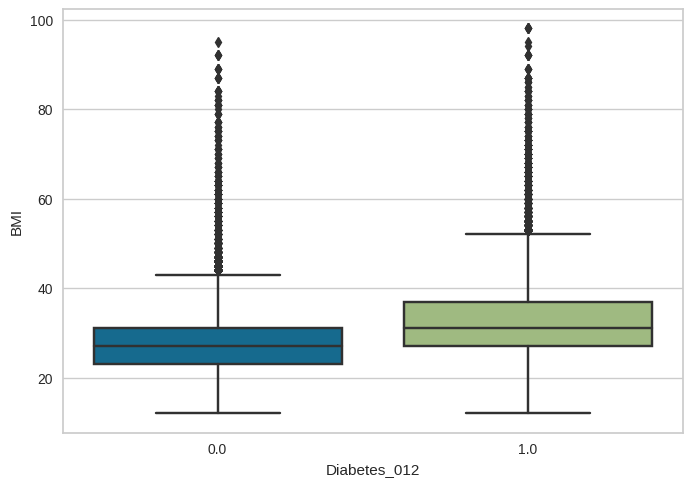

In [15]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

Let's transform this variable - there are quite a few outliers which might make convergence difficult later. Let's transform this to mirror the categories used in the field:

below 18.5 - This is described as underweight.

between 18.5 and 24.9 – This is described as the 'healthy range'. 

between 25 and 29.9 – This is described as overweight. 

30 and above - This is described as obesity.

source: https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-loss/body-mass-index-bmi#:~:text=BMI%20ranges&text=between%2018.5%20and%2024.9%20%E2%80%93%20This,is%20described%20as%20severe%20obesity

In [16]:
data['BMI'].mask(data['BMI'] < 18.5, 0, inplace=True)
data['BMI'].mask((data['BMI'] >= 18.5) & (data['BMI'] <= 24.9), 1, inplace=True)
data['BMI'].mask((data['BMI'] >= 25) & (data['BMI'] <= 29.9), 2, inplace=True)
data['BMI'].mask((data['BMI'] >= 30) & (data['BMI'] <= 34.9), 3, inplace=True)
data['BMI'].mask((data['BMI'] >= 35) & (data['BMI'] <= 39.9), 4, inplace=True)
data['BMI'].mask((data['BMI'] >= 40), 5, inplace=True)

Text(0.5, 1.0, 'Diabetes')

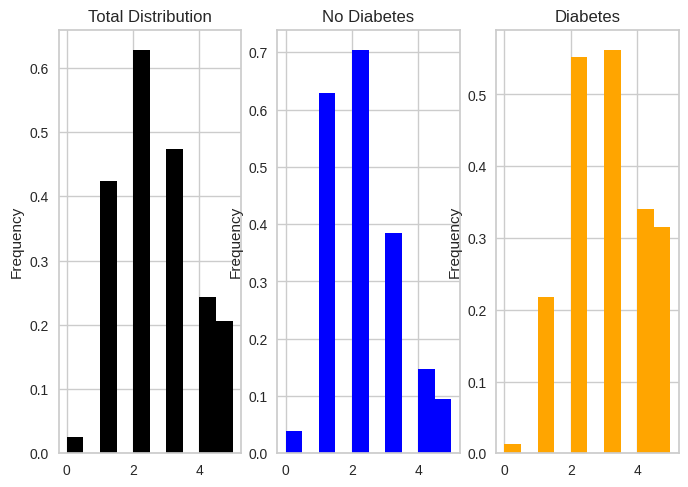

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Diabetes")


## Categorical Predictors
The rest of our predictors are categorical or binary. 
This requires a different approach than what we can do with a continous valued predictor.


HighBP

HighChol

CholCheck

BMI

Smoker

Stroke

HeartDiseaseorAttack

PhysActivity

Fruits

Veggies

HvyAlcoholConsump

AnyHealthcare

NoDocbcCost

GenHlth

DiffWalk

Sex 

Age    

Education

Income                  


In [20]:
def var_hist(var, data,fig,w,h):
    
    plt.tight_layout()
    gs = fig.add_gridspec(5,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    ax7 = fig.add_subplot(gs[4, 0])
    ax8 = fig.add_subplot(gs[4, 1])
    plt.tight_layout()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.suptitle(var, fontsize=14)
    data[var].plot(ax=ax1,kind='hist',color='black', density=True).set_title("Total Distribution")
    data.query('Diabetes_012 == 0')[var].plot(ax=ax2,kind='hist',color='blue', density=True).set_title("No Diabetes")
    data.query('Diabetes_012 == 1')[var].plot(ax=ax3,kind='hist',color='orange', density=True).set_title("Diabetes")
    desc = data[var].groupby(data['Diabetes_012']).describe()
    desc.insert(0, 'Class', desc.index)
    table = desc 
    cell_text = []
    for row in range(len(table)):
        cell_text.append(round(table.iloc[row],2))
    table = ax5.table(cellText=cell_text, colLabels=table.columns, loc=ax5)
    ax5.axis('off')
    table.set_fontsize(10)
    ax5.set_title(var + " - descriptive statistics")
    plt.tight_layout()
    crosstab = pd.crosstab(data[var],data['Diabetes_012'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    ct_data = {'Chi-square: ':  [chi2],
            'p-value: ': [p],
            'DOF: ': [dof]}
    df = pd.DataFrame(ct_data)
    cell_text_chi = []
    for row in range(len(df)):
        cell_text_chi.append(df.iloc[row])
    table_chi = ax6.table(cellText=cell_text_chi,colLabels=df.columns, loc=ax6)
    ax6.axis('off')
    table_chi.set_fontsize(10)
    ax6.set_title(var + " - Chi Square Test")
    plt.tight_layout()
    act = pd.DataFrame(crosstab)
    act_cell_text = []
    for row in range(len(act)):
        act_cell_text.append(act.iloc[row])
    table_act = ax7.table(cellText=act_cell_text,colLabels=act.columns, loc=ax7)
    ax7.axis('tight')
    ax7.axis('off')
    table_act.set_fontsize(10)
    ax7.set_title("Chi Square - Actual Frequencies")
    plt.tight_layout()
    exp = pd.DataFrame(expected)
    exp_cell_text = []
    for row in range(len(exp)):
        exp_cell_text.append(exp.iloc[row])
    table_exp = ax8.table(cellText=exp_cell_text,colLabels=exp.columns, loc=ax8)
    ax8.axis('off')
    table_exp.set_fontsize(10)
    ax8.set_title("Chi Square - Expected Frequencies")

In [21]:
from sklearn.feature_selection import chi2

X = data.drop('Diabetes_012',axis=1)
y = data['Diabetes_012']

chi_scores = chi2(X,y)
chi_scores

(array([1.09864058e+04, 3.06327140e+02, 2.95415086e+03, 1.46904004e+03,
        6.50723330e+01, 4.29785290e+00, 1.10646822e+04, 3.98344428e+02,
        1.41588985e+03, 1.05915056e+02, 2.25497025e+04, 1.05667590e+03,
        7.33687676e+03, 2.11112842e+02, 1.14122228e+03, 5.35824926e+03,
        1.52146330e+04]),
 array([0.00000000e+000, 1.37831253e-068, 0.00000000e+000, 0.00000000e+000,
        7.21986585e-016, 3.81605215e-002, 0.00000000e+000, 1.26279770e-088,
        7.40533575e-310, 7.69646321e-025, 0.00000000e+000, 8.61594168e-232,
        0.00000000e+000, 7.85377008e-048, 3.62748432e-250, 0.00000000e+000,
        0.00000000e+000]))

In [22]:
p_values = pd.DataFrame(chi_scores[1],index = X.columns)
print(p_values)
print("p-value greater than 0.05:")
for p in p_values.index:
    val = p_values.loc[p]
    if val.loc[0] > 0.05:
        print(val.name)

                           0
BMI             0.000000e+00
Smoker          1.378313e-68
Stroke          0.000000e+00
PhysActivity    0.000000e+00
AnyHealthcare   7.219866e-16
NoDocbcCost     3.816052e-02
GenHlth         0.000000e+00
MentHlth        1.262798e-88
PhysHlth       7.405336e-310
Sex             7.696463e-25
Age             0.000000e+00
Education      8.615942e-232
Income          0.000000e+00
Marital         7.853770e-48
PoorHlth       3.627484e-250
HeartAttack     0.000000e+00
HighBP          0.000000e+00
p-value greater than 0.05:


In [23]:
#data = data.drop(columns=['NoDocbcCost'],axis=1)
var_list = list(data.drop('Diabetes_012', axis=1).columns)
var_idx = -1

### Smoker

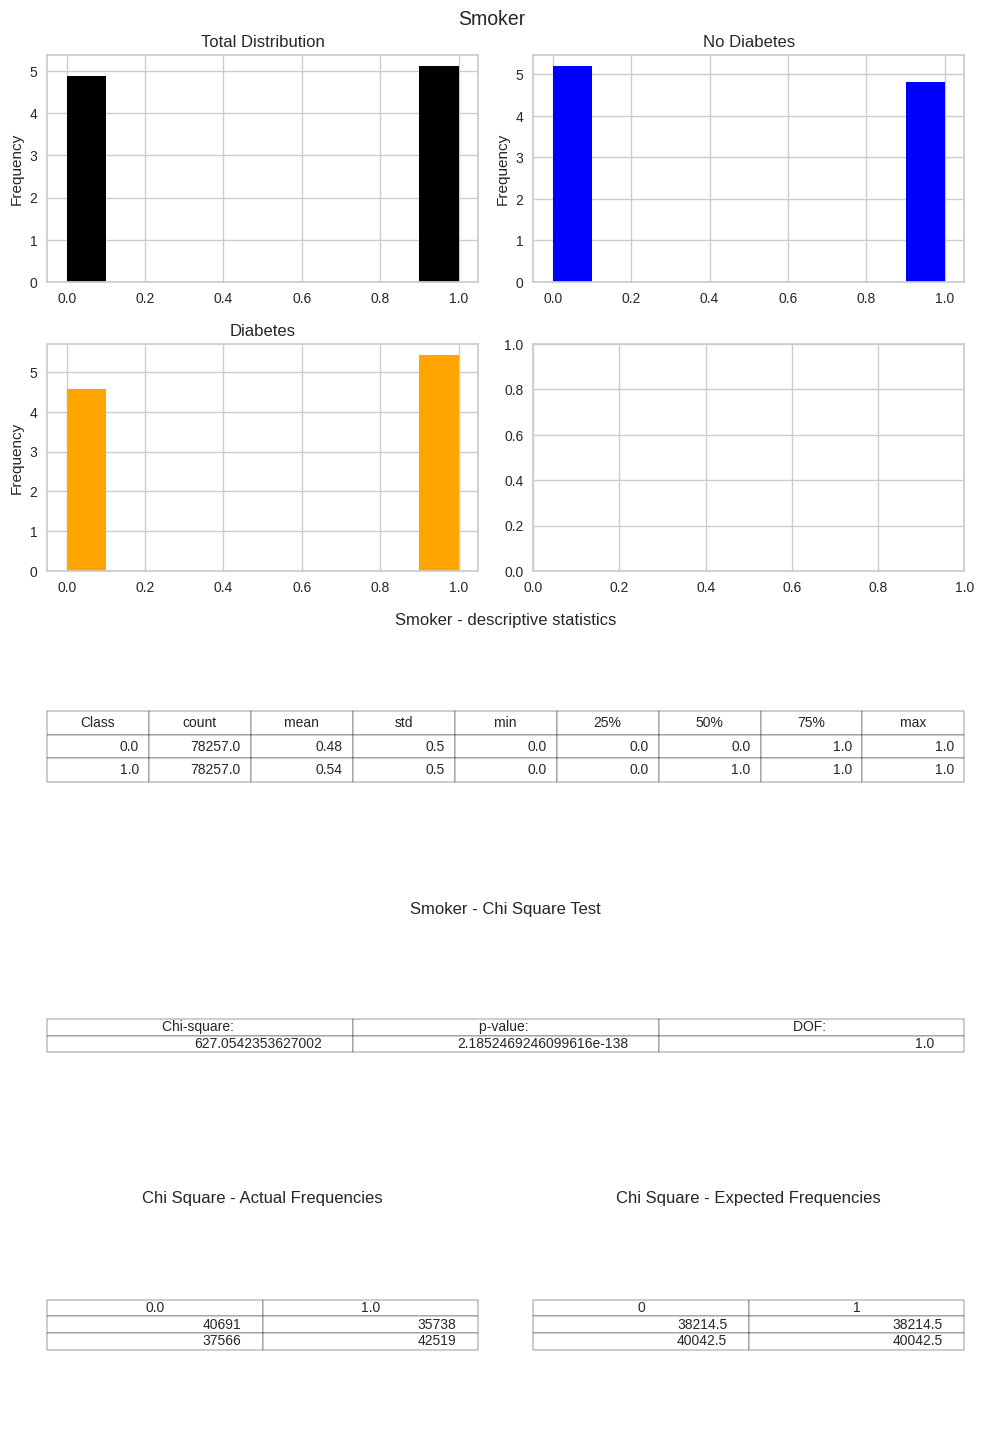

In [24]:
var_idx = var_idx + 1
var = var_list[1]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Stroke

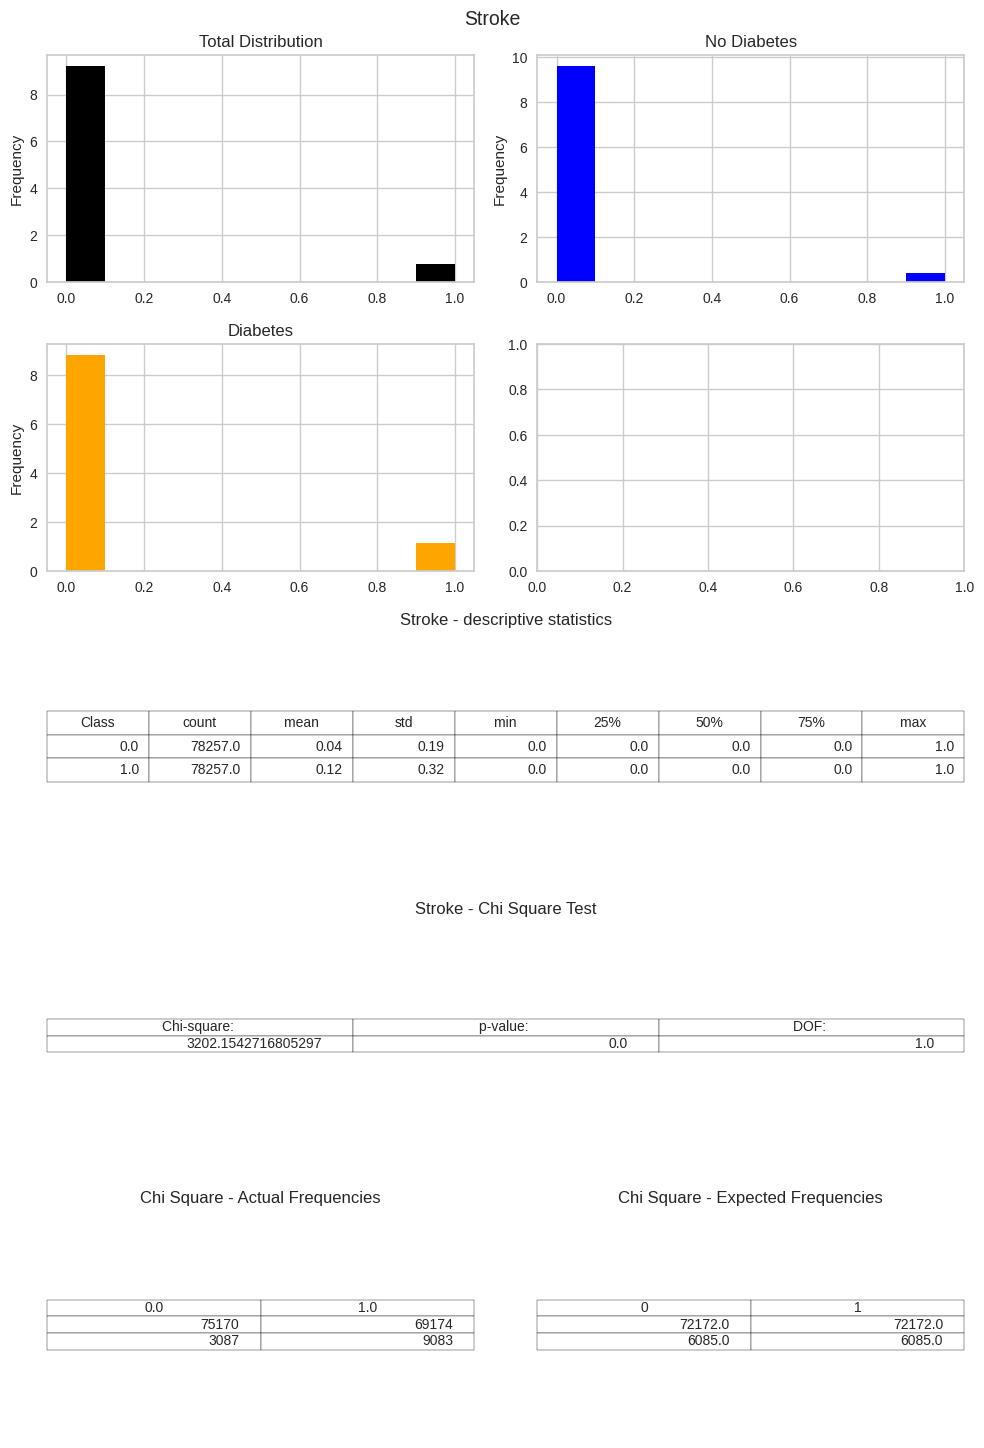

In [26]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Activity

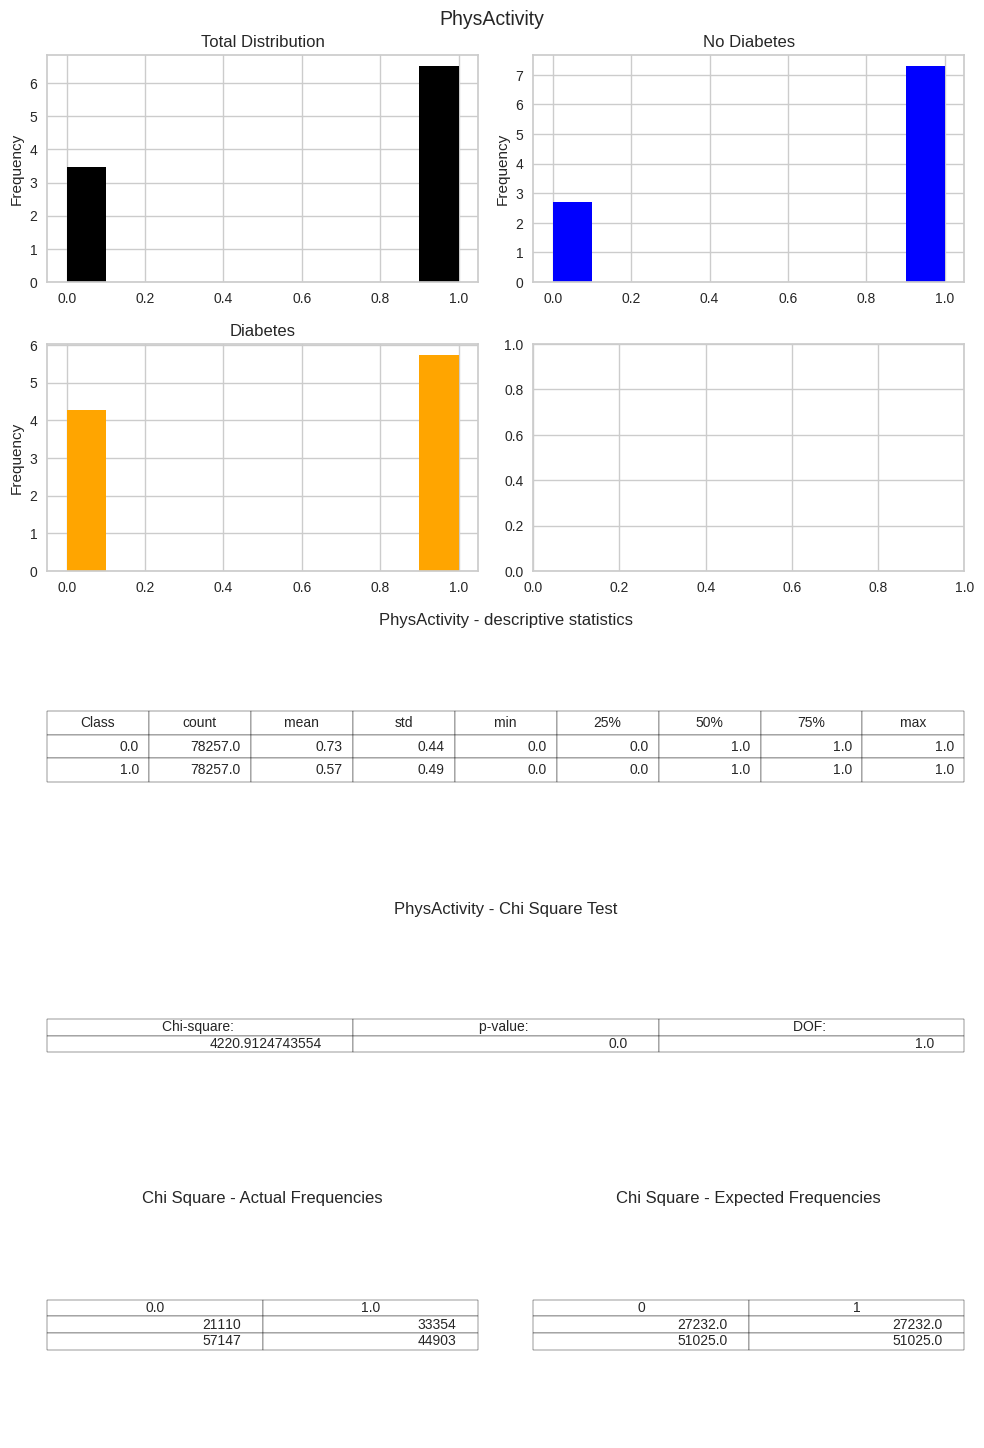

In [27]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Any Healthcare

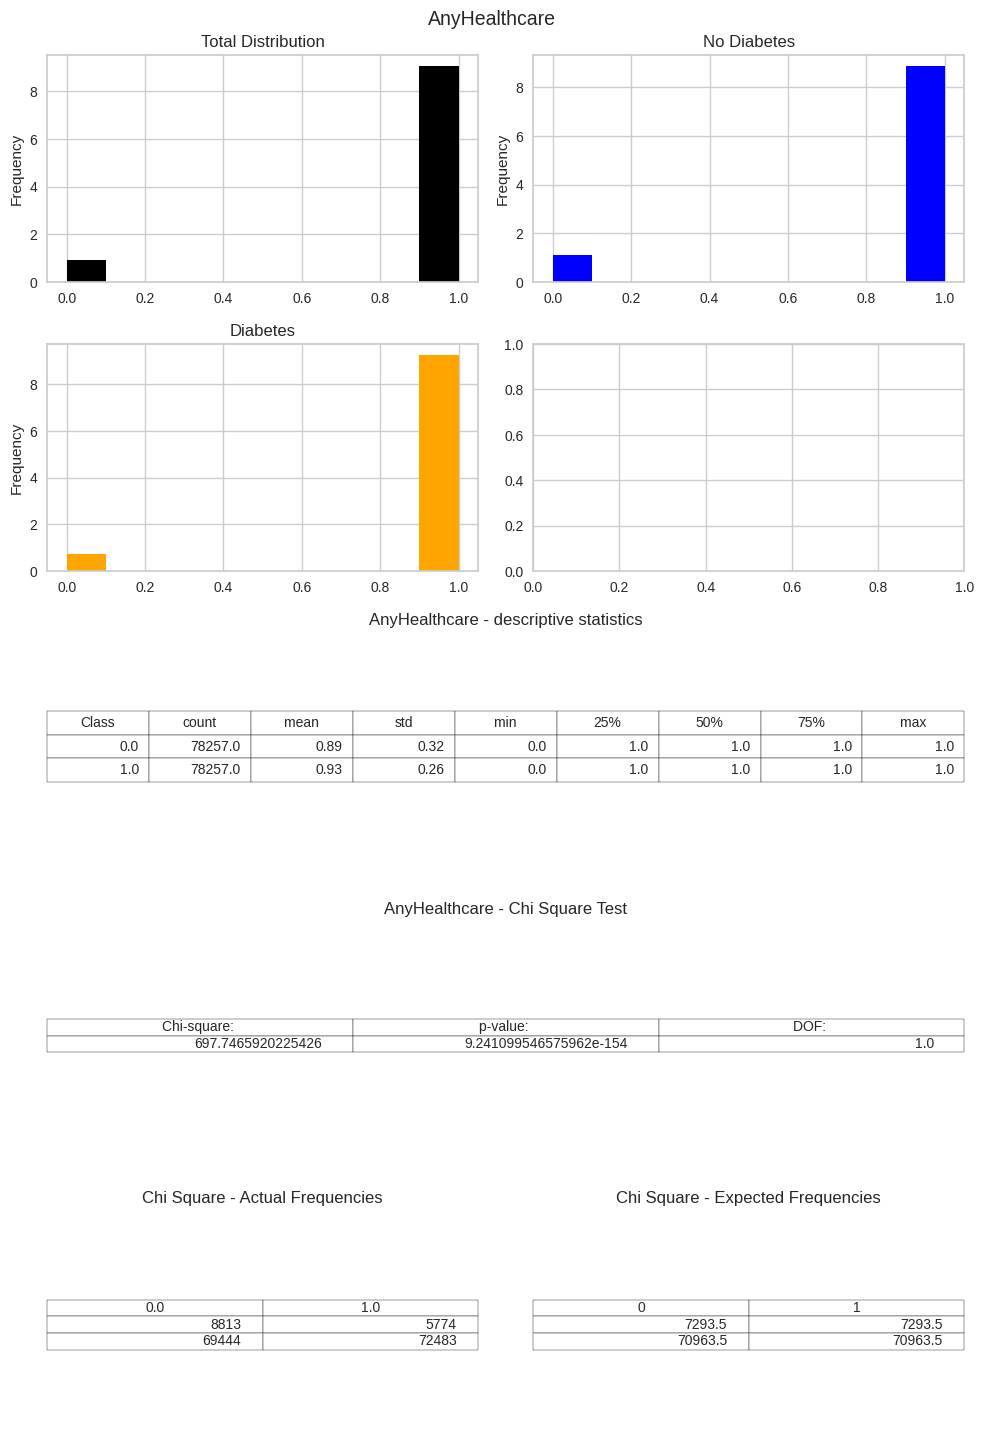

In [28]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### No Doctor Because of Cost

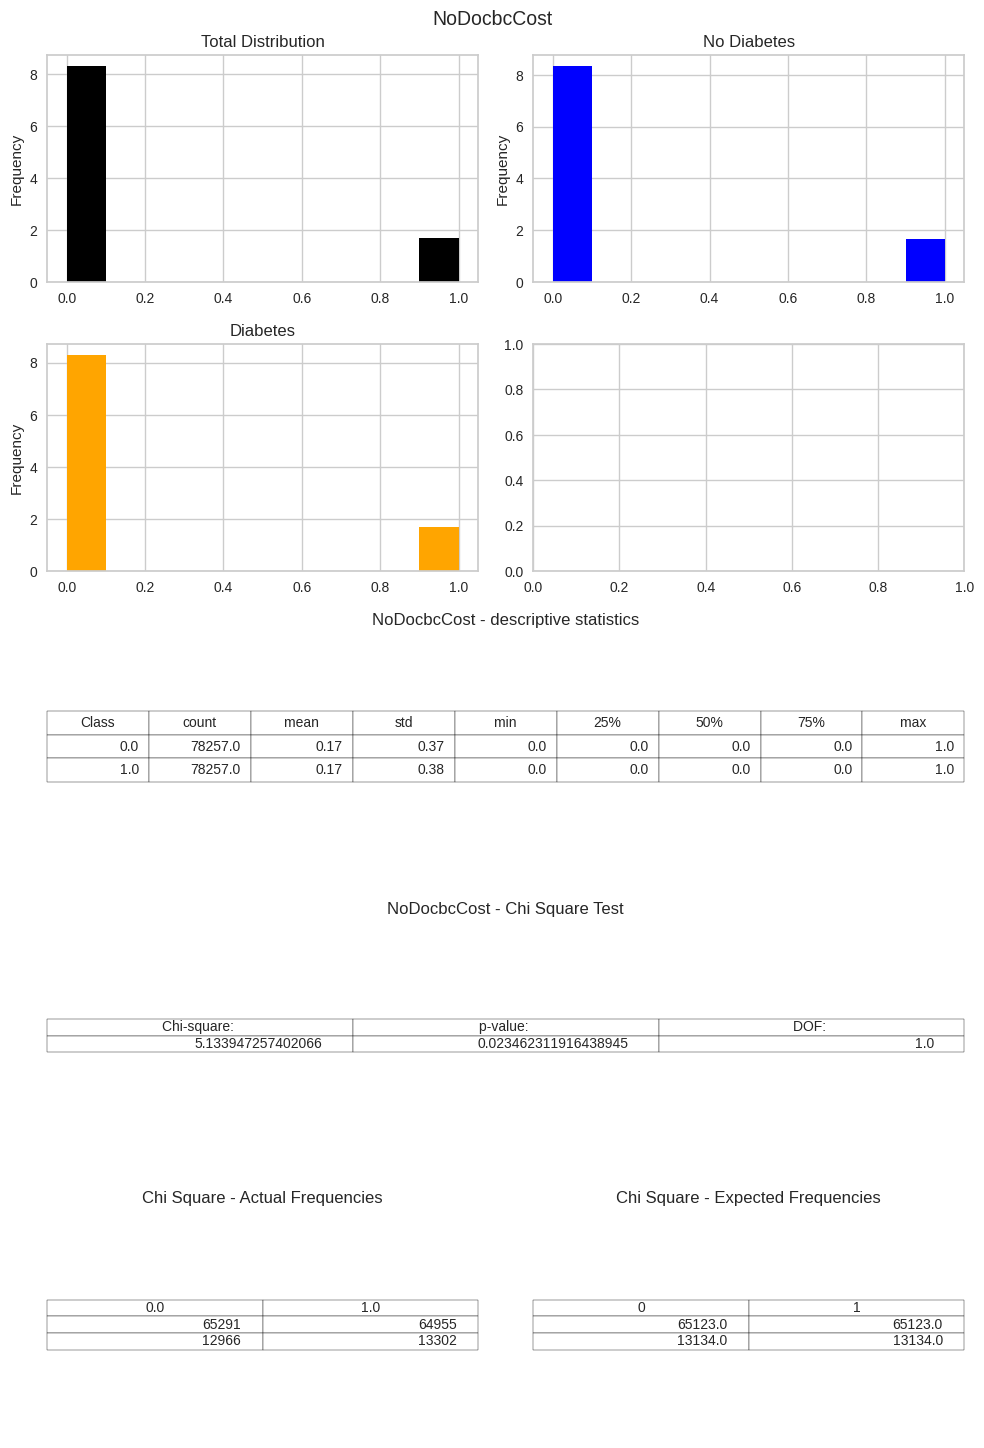

In [29]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### General Health

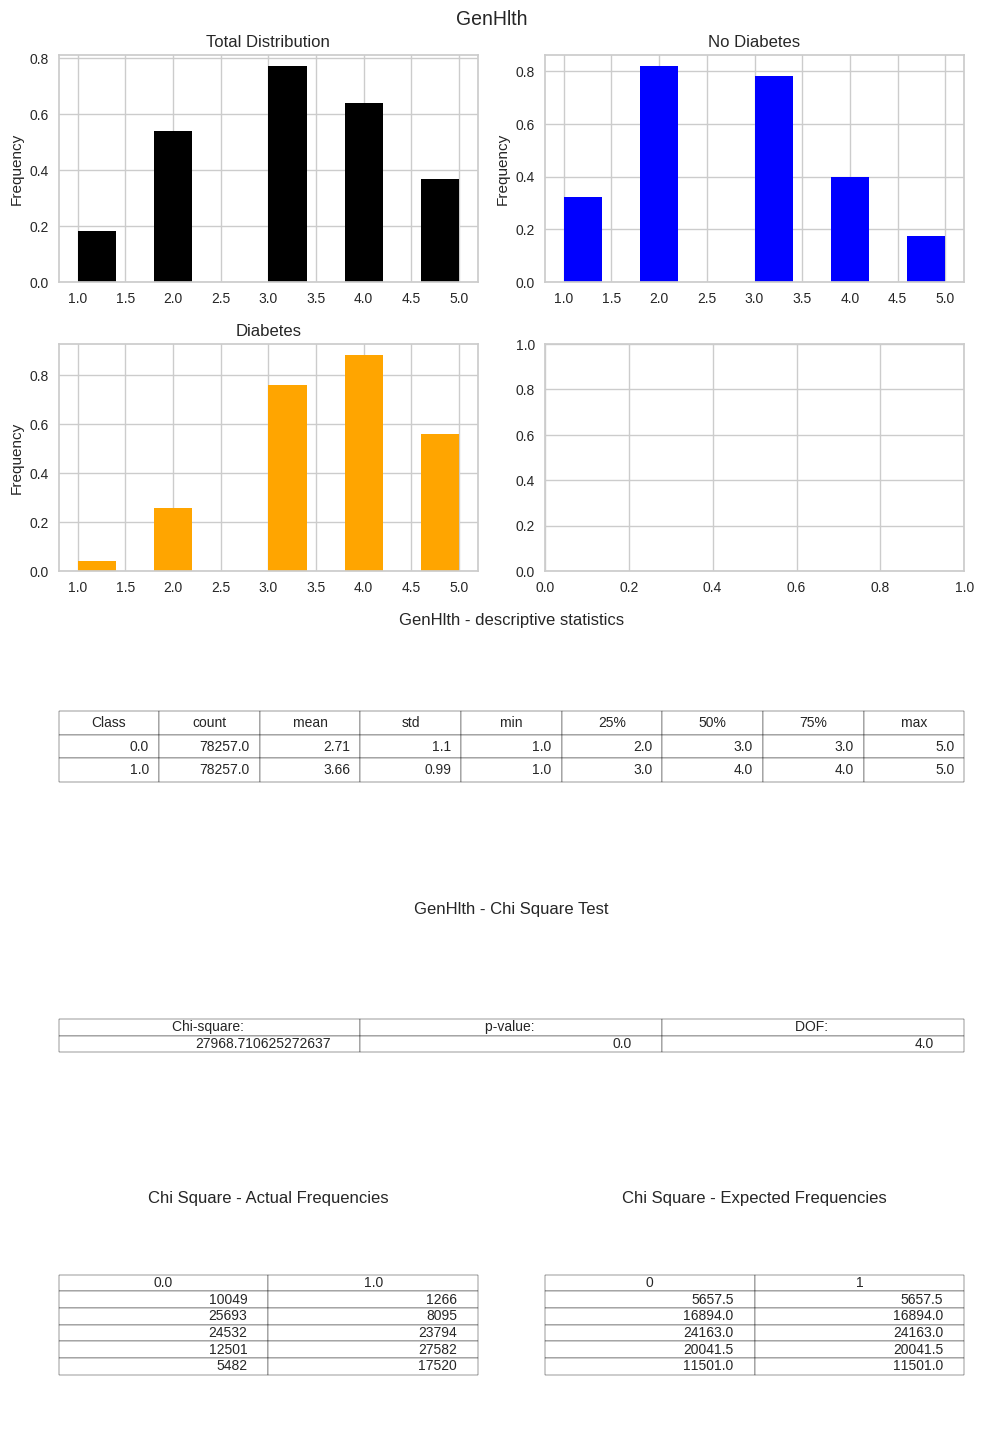

In [30]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Mental Health

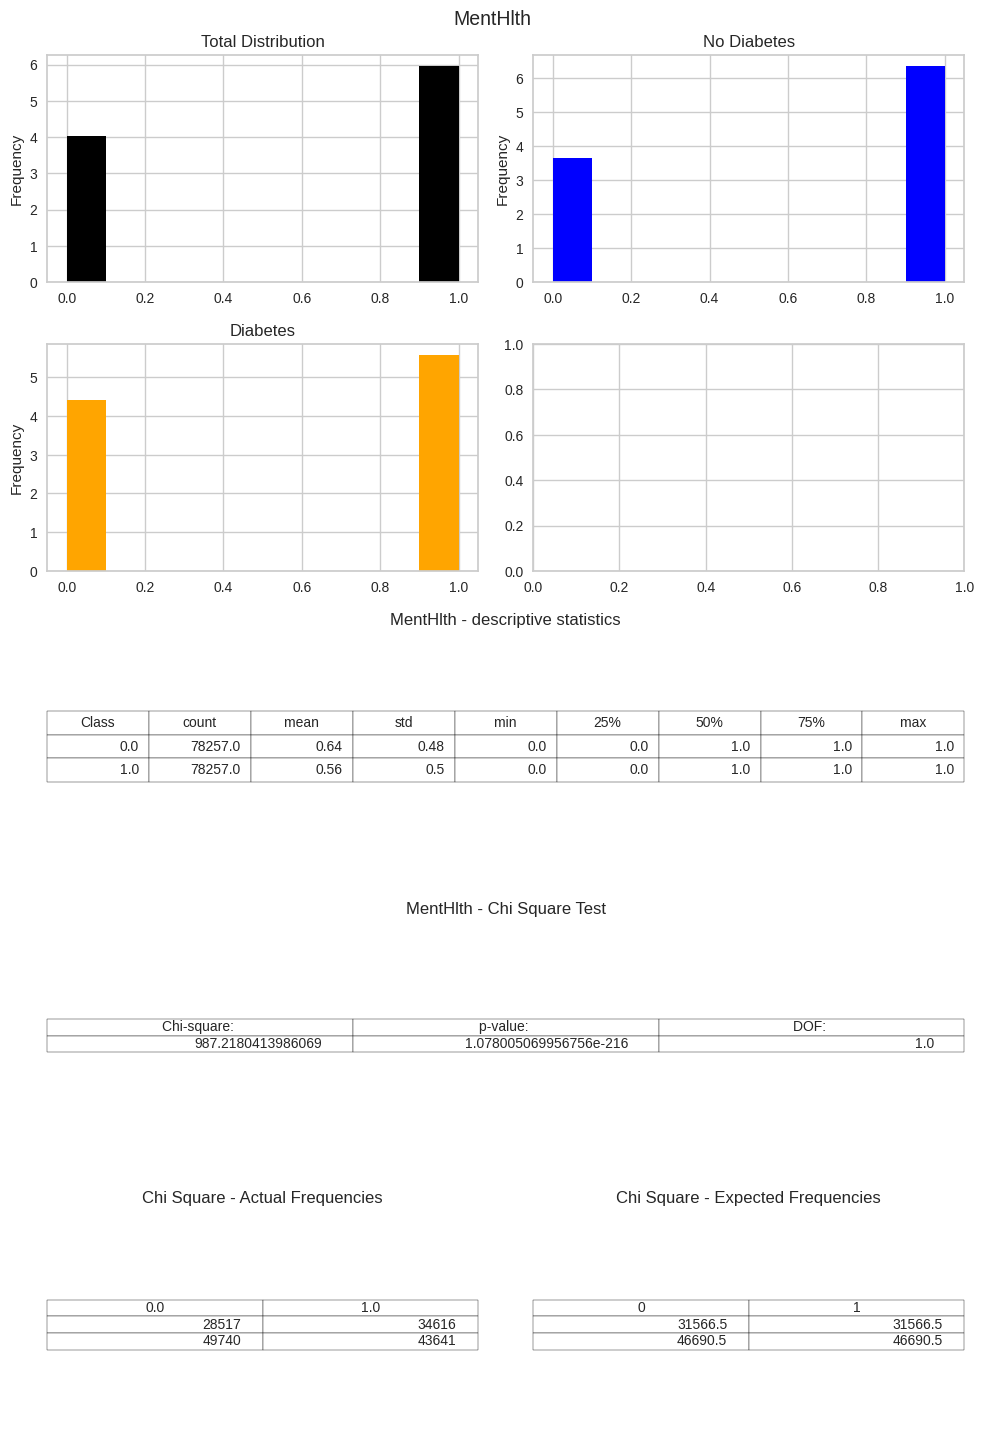

In [31]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Health

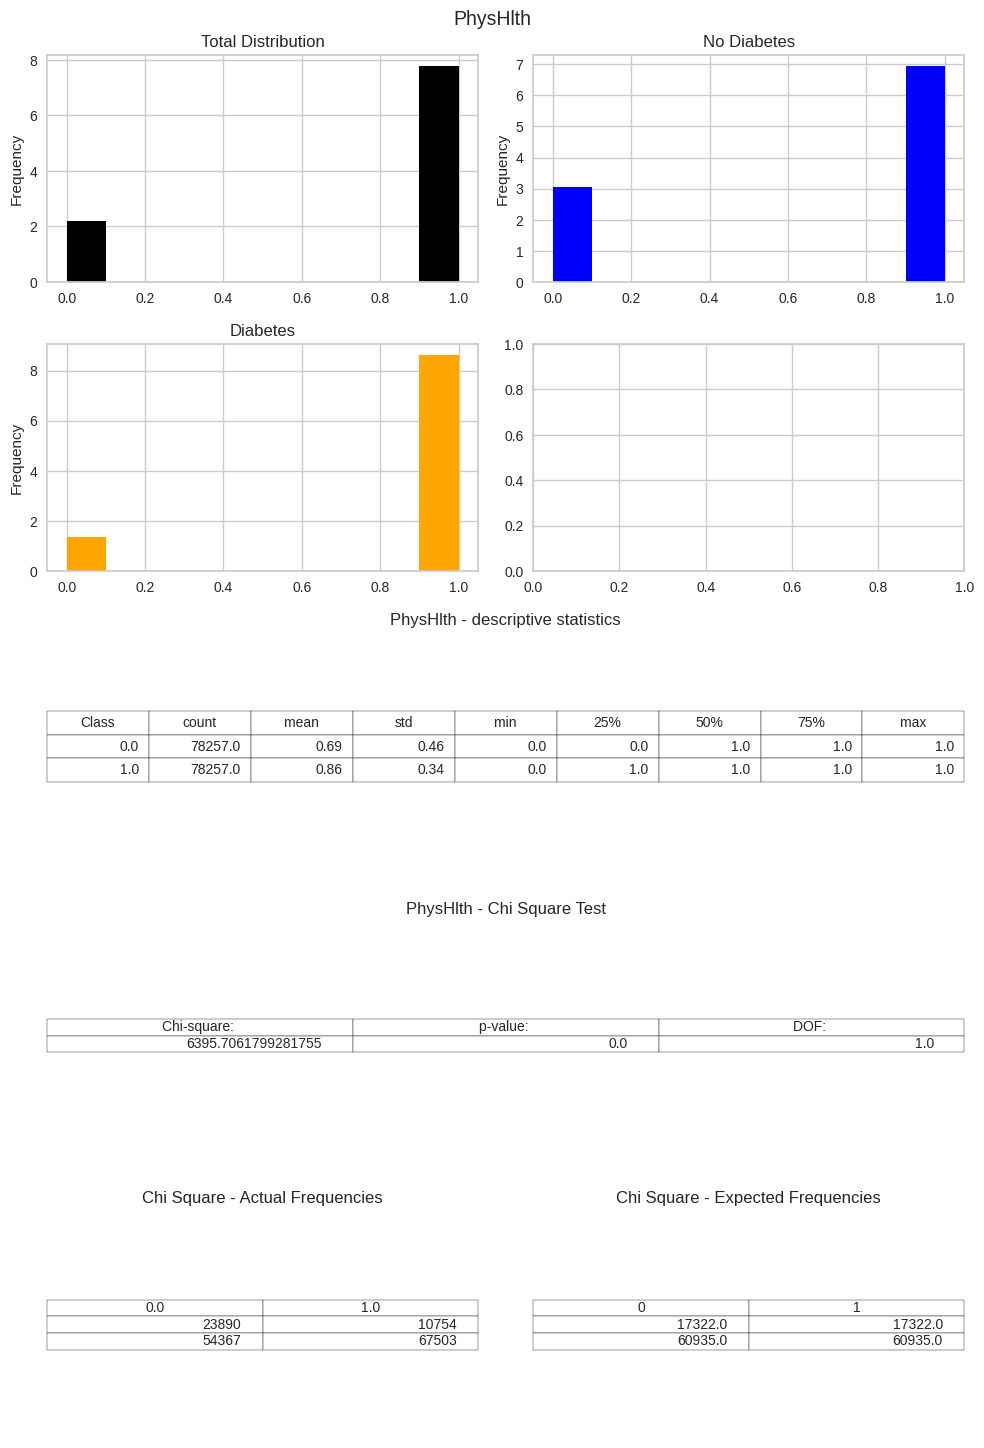

In [32]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Sex

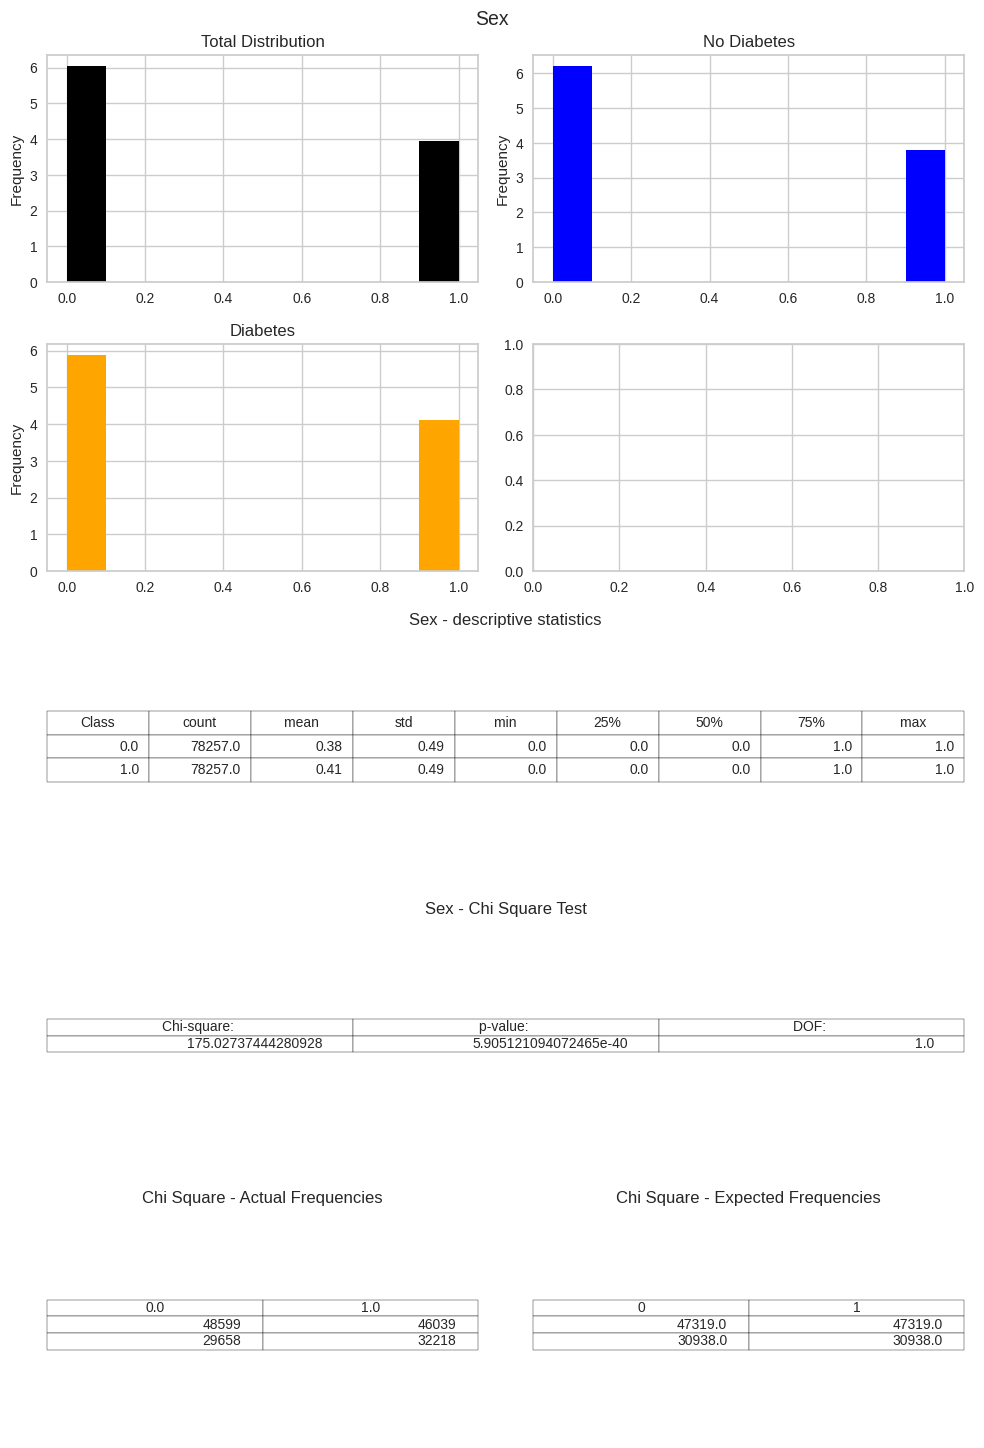

In [33]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Age

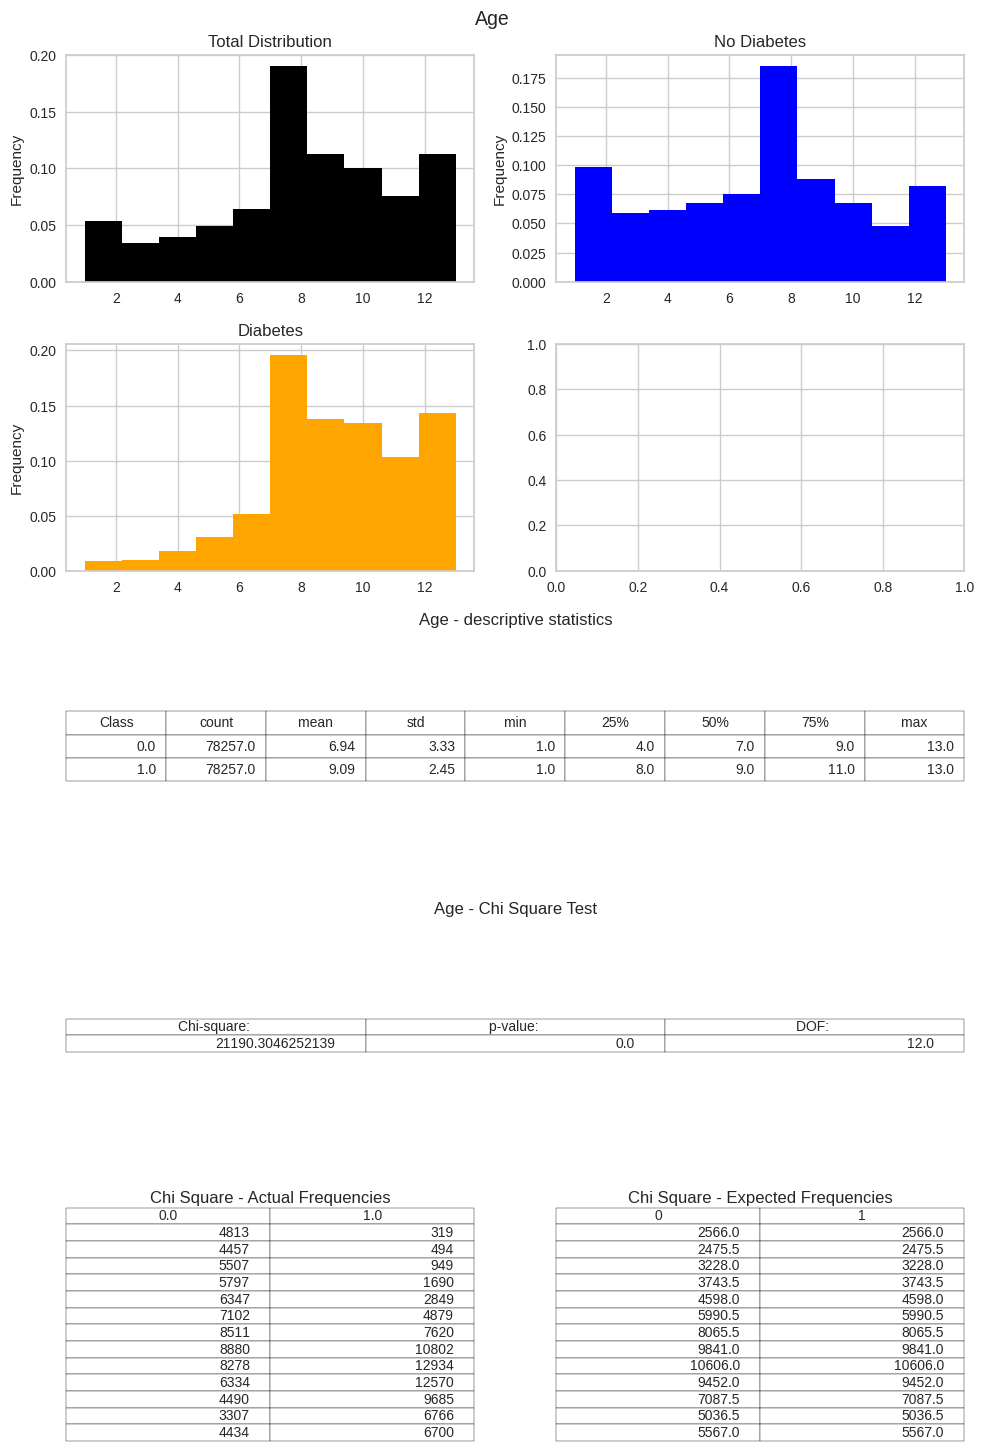

In [34]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Education

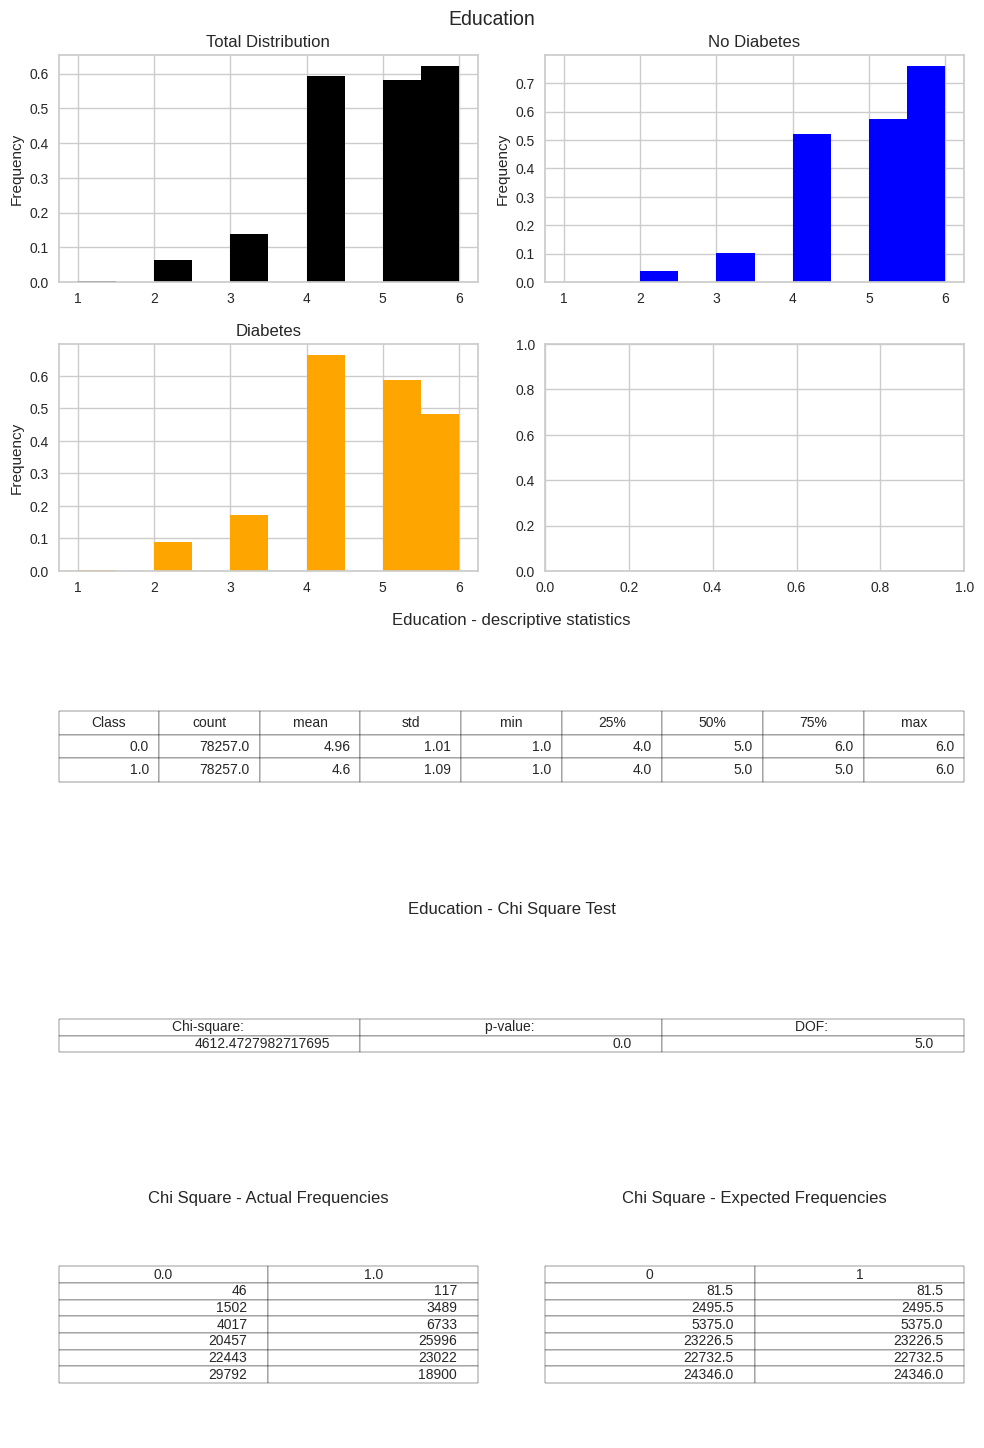

In [35]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Income

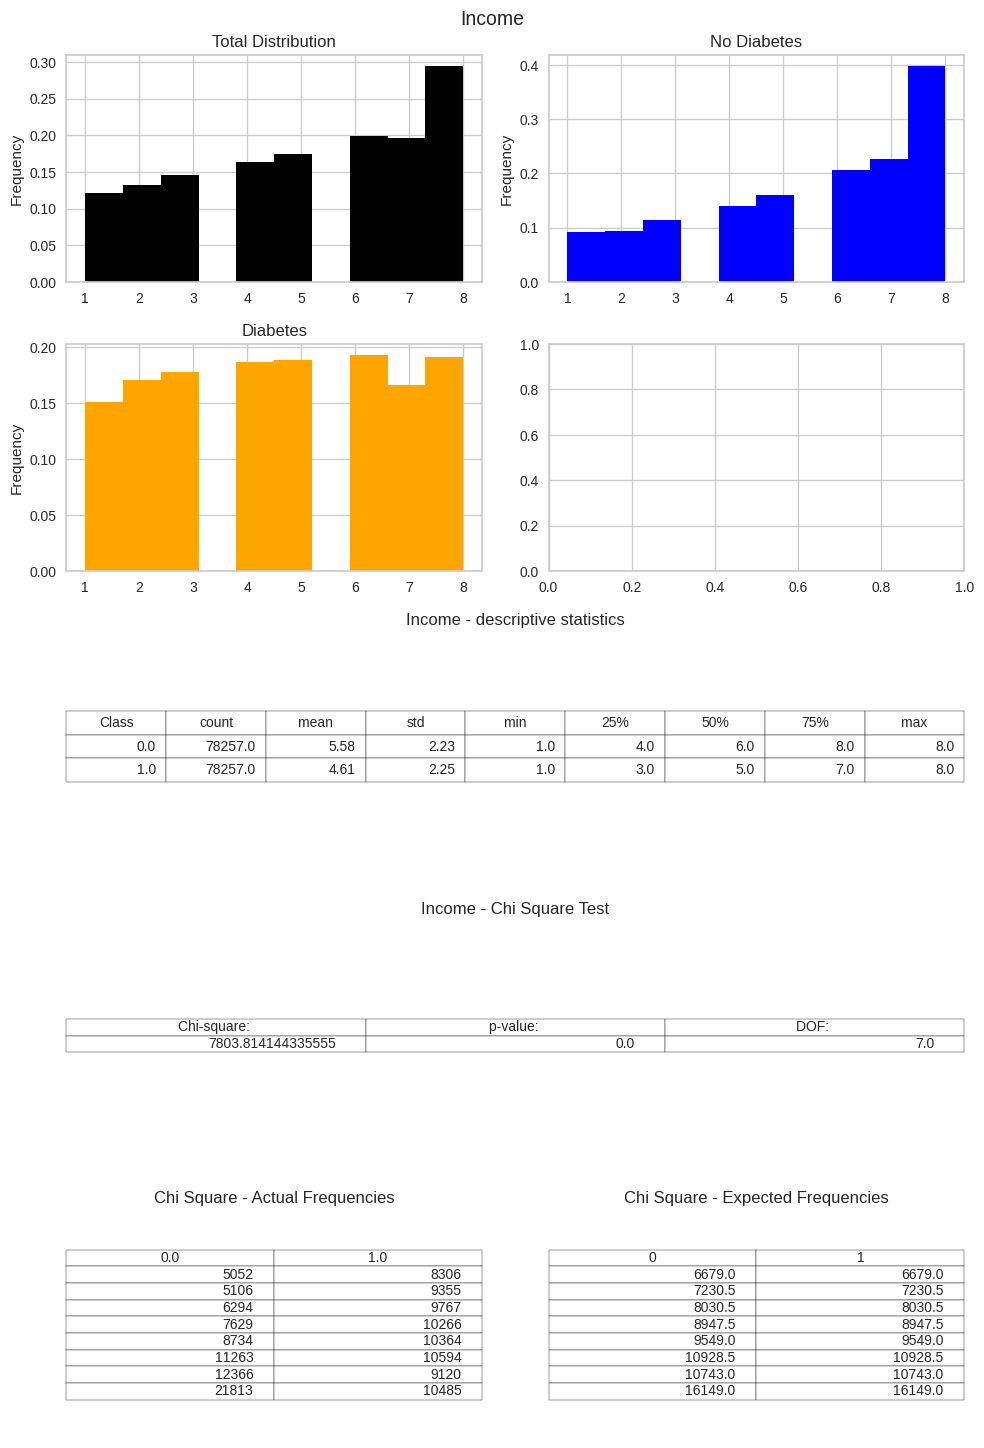

In [36]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Marital Status

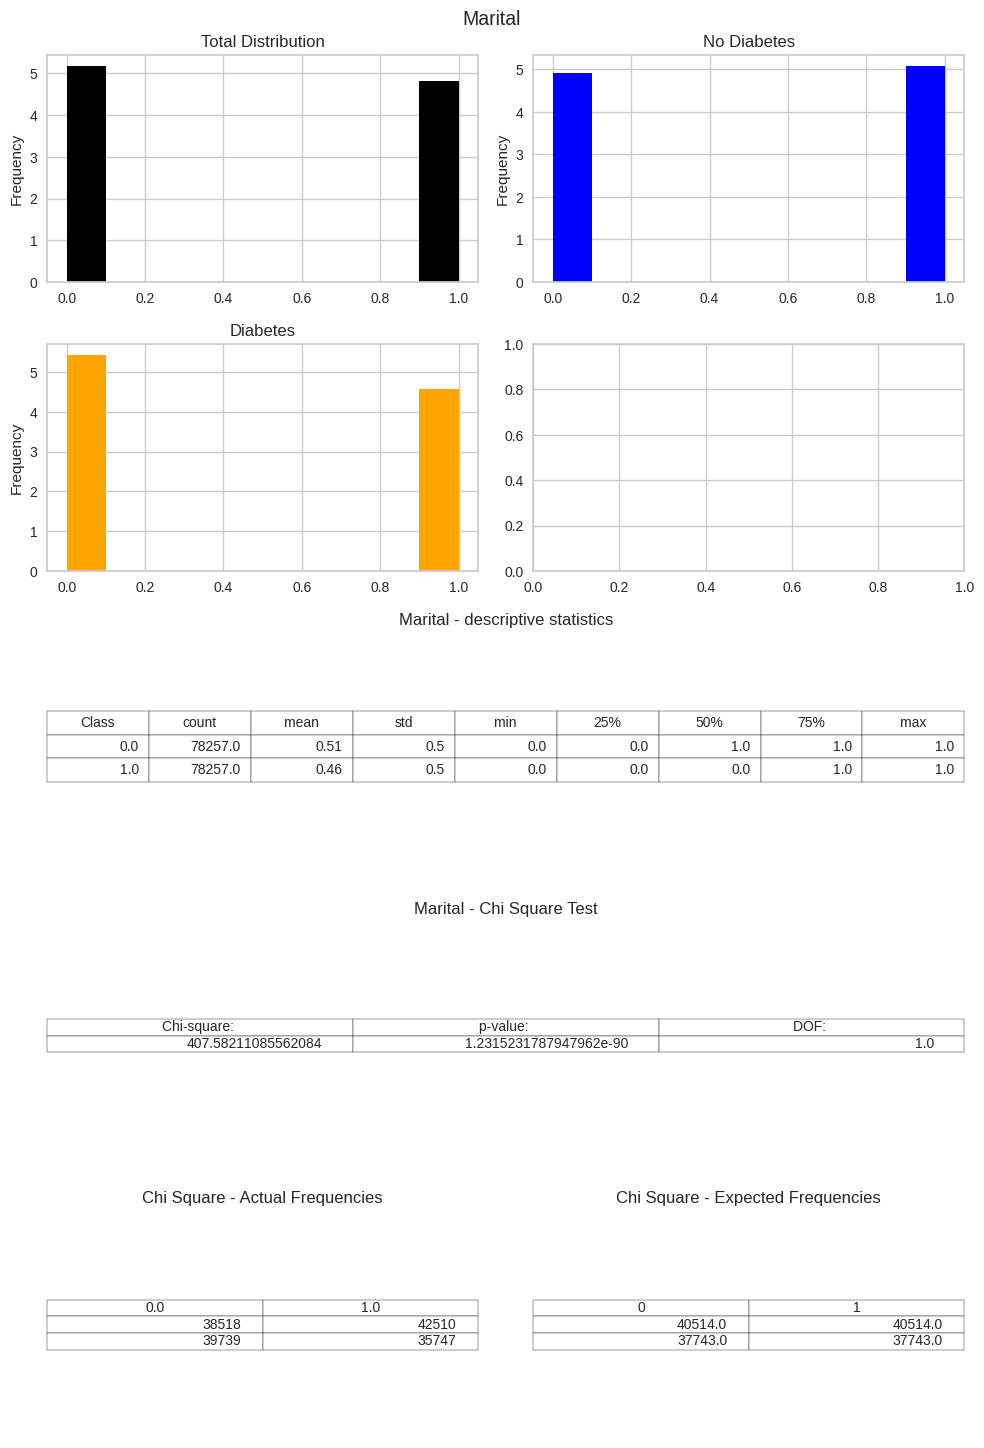

In [37]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Poor Health

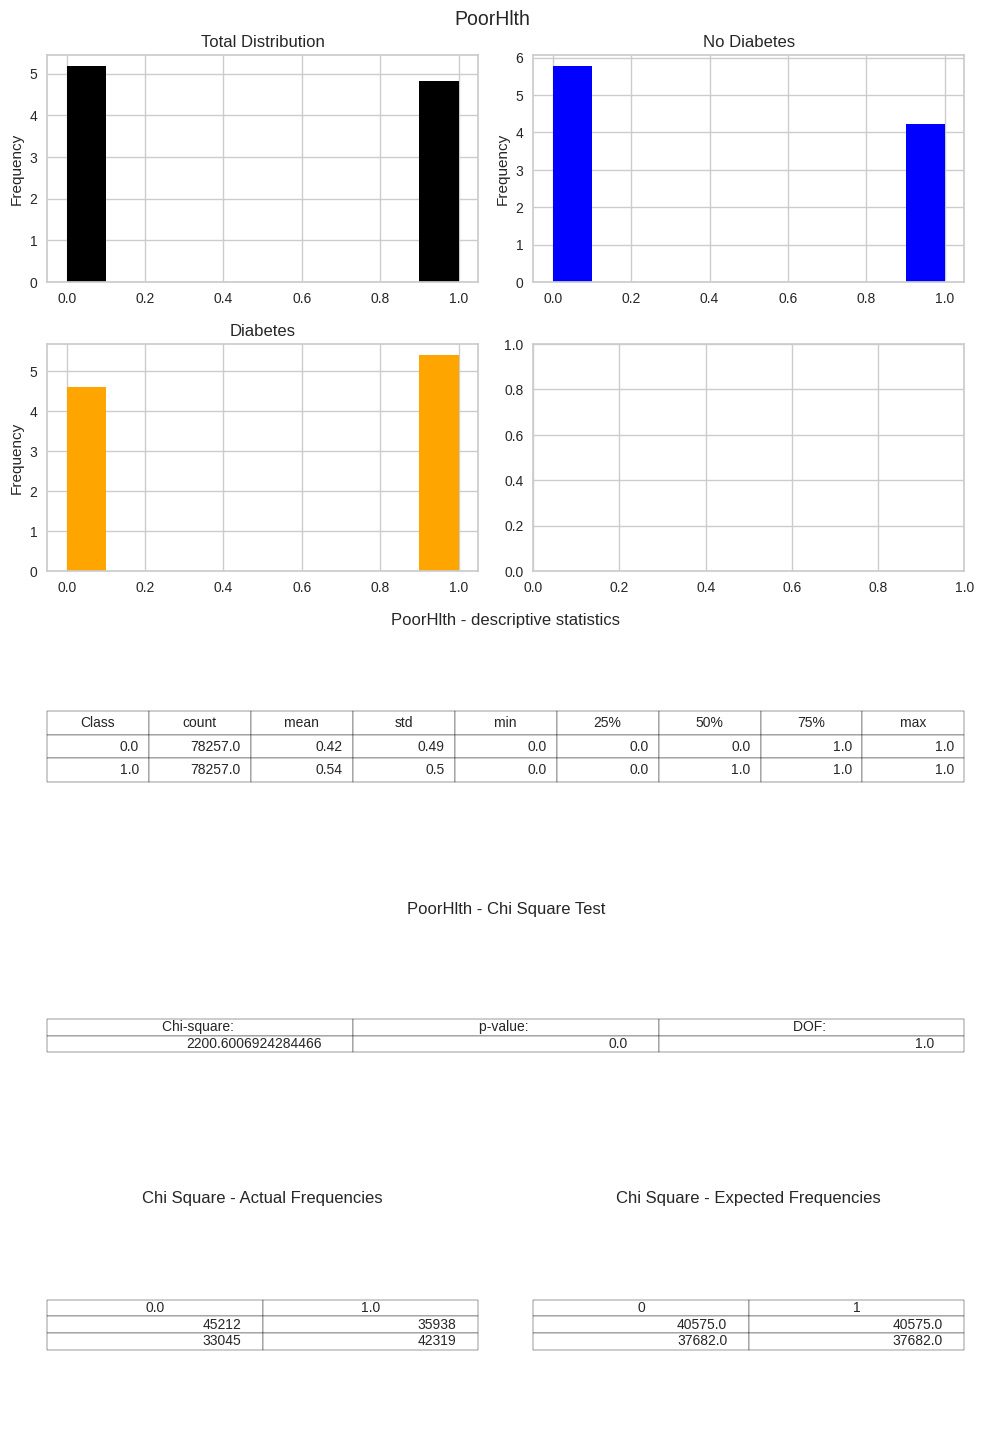

In [38]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heart Attack

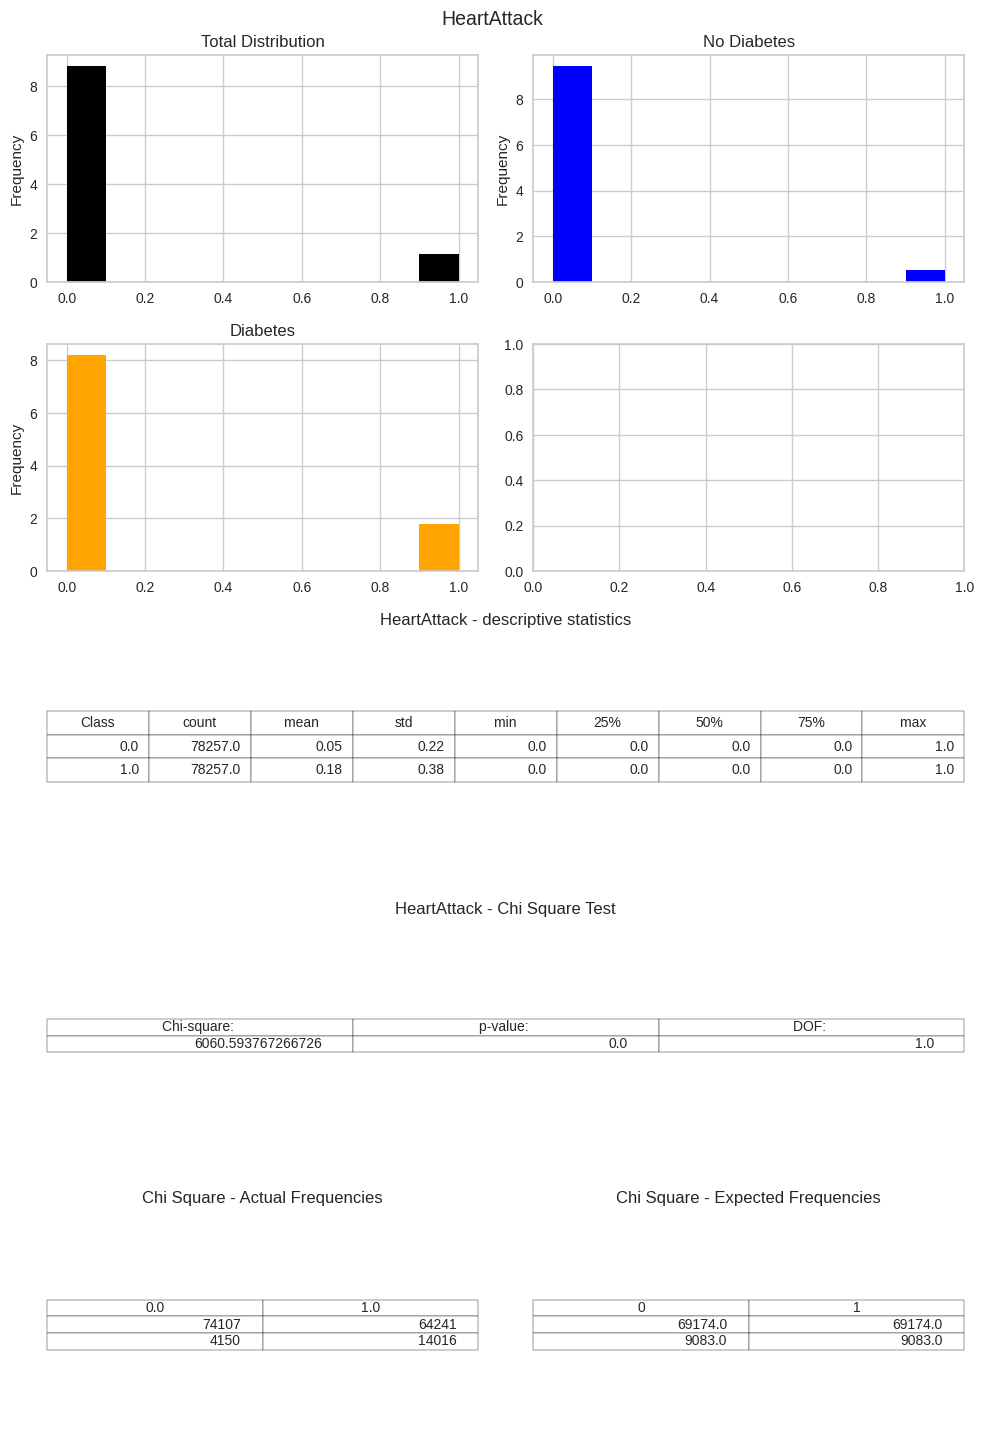

In [39]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### High Blood Pressure

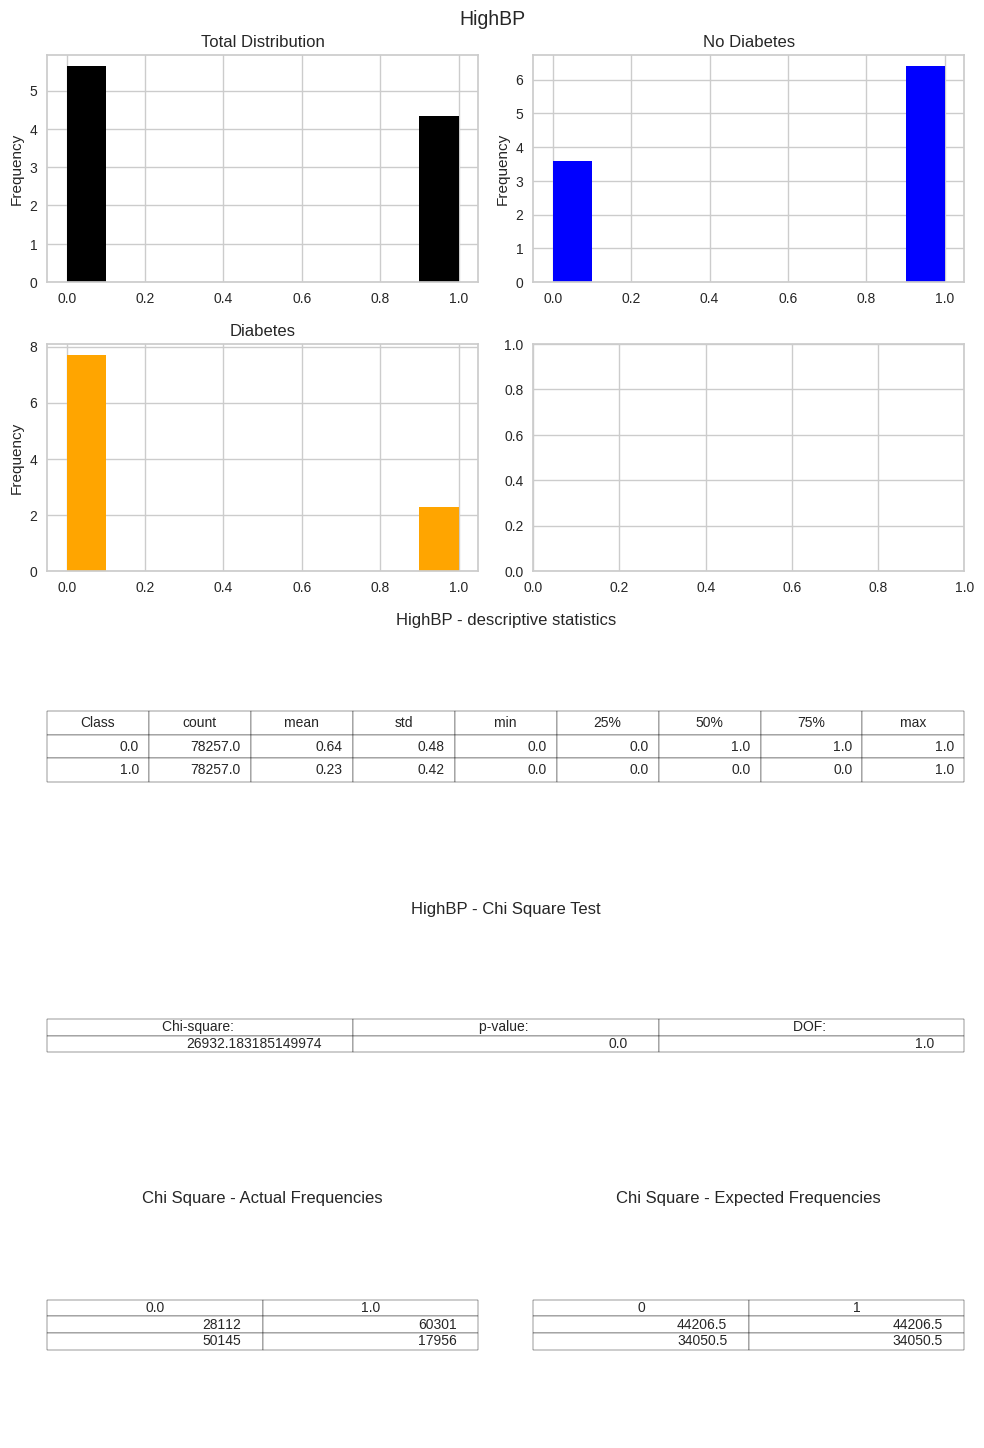

In [40]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

## Collinearity & Variance

When using regression techniques, we make the statistical assumption that are predictors are independent, or not related. Thus, it is important that we drop any strongly intercorrelated features from our analysis. 

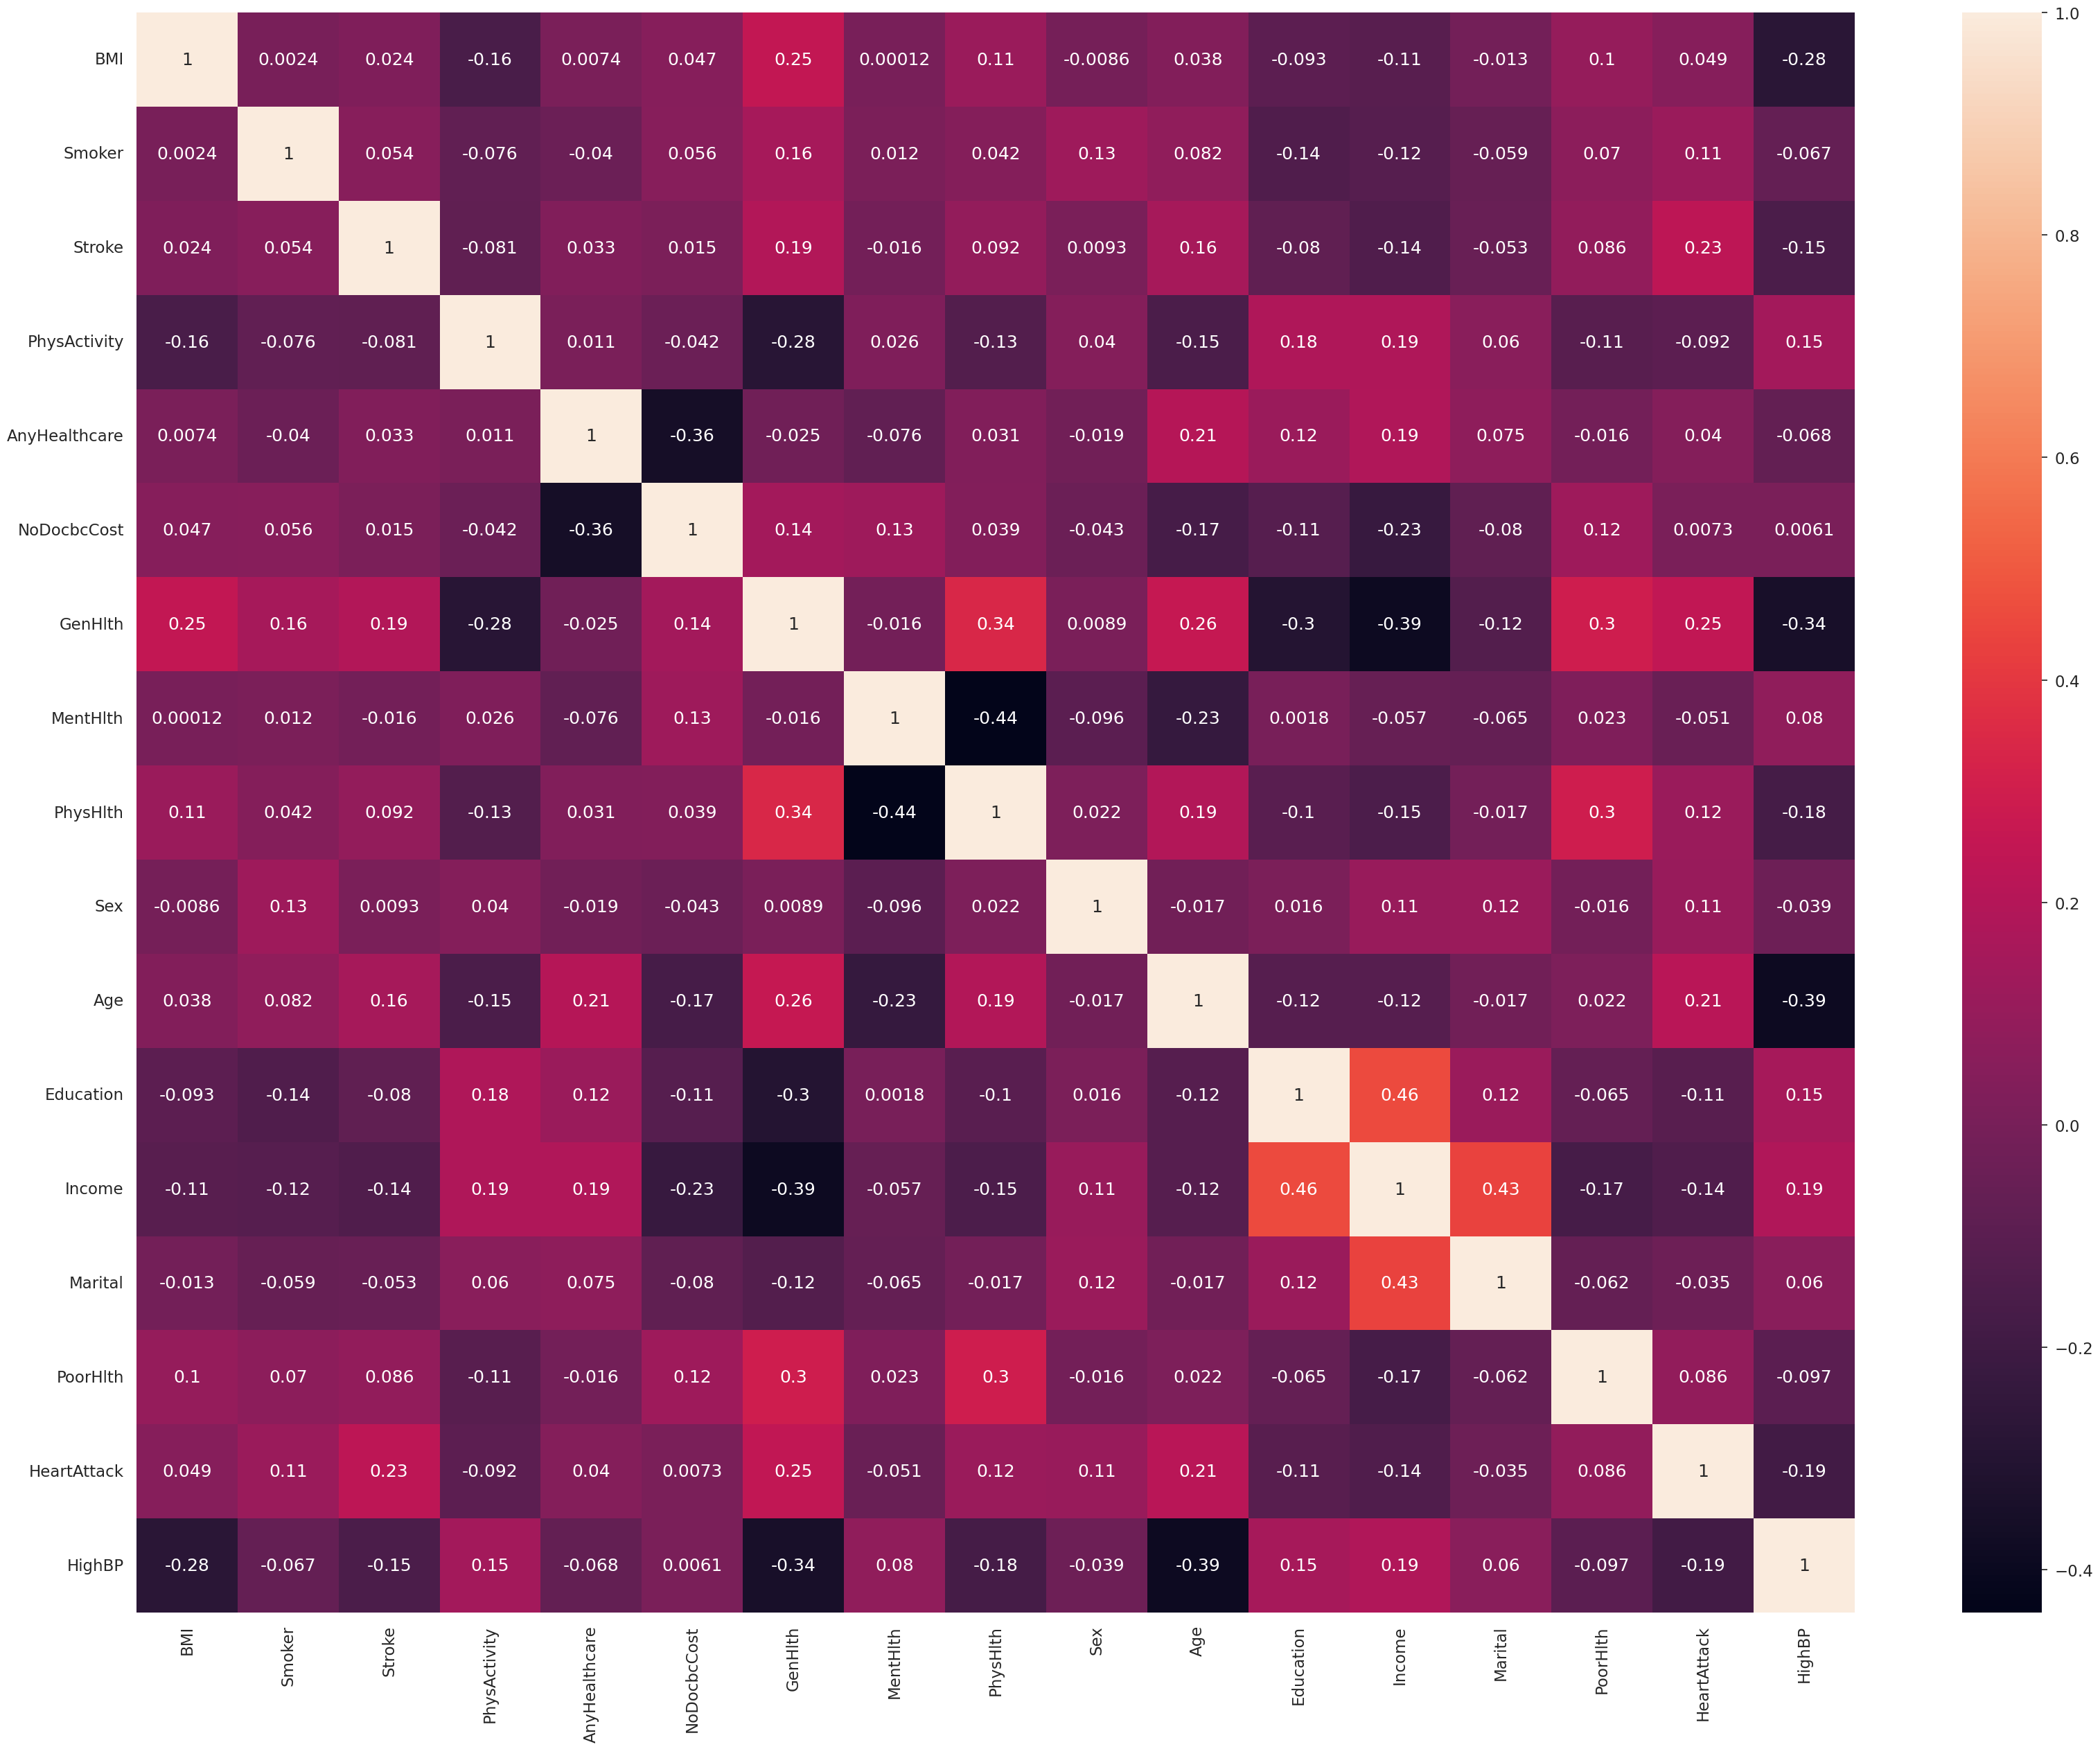

In [42]:
data_full = data
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are actually not many values that are strongly intercorrelated. Usually a strong correlation is considered to be 0.70 or greater. However, there are some variables that are moderately intercorrelated.

In [43]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,5.400518
1,Smoker,2.148707
2,Stroke,1.189813
3,PhysActivity,3.073548
4,AnyHealthcare,12.068828
5,NoDocbcCost,1.438003
6,GenHlth,12.499080
7,MentHlth,3.143612
8,PhysHlth,6.676956
9,Sex,1.756544


We will drop variables one by one, starting with the highest VIF scores.

In [44]:
data = data.drop(columns=['Education'])

In [45]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,5.286300
1,Smoker,2.148306
2,Stroke,1.189767
3,PhysActivity,2.931788
4,AnyHealthcare,11.496810
5,NoDocbcCost,1.418363
6,GenHlth,12.402072
7,MentHlth,3.032713
8,PhysHlth,6.555936
9,Sex,1.753142


In [46]:
data = data.drop(columns=['GenHlth'])

In [47]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,4.877389
1,Smoker,2.114381
2,Stroke,1.183833
3,PhysActivity,2.922877
4,AnyHealthcare,11.230305
5,NoDocbcCost,1.376106
6,MentHlth,2.813206
7,PhysHlth,5.773786
8,Sex,1.742695
9,Age,7.939844


In [48]:
data = data.drop(columns=['AnyHealthcare'])

In [49]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,4.708069
1,Smoker,2.111833
2,Stroke,1.182391
3,PhysActivity,2.882961
4,NoDocbcCost,1.306315
5,MentHlth,2.702070
6,PhysHlth,5.579005
7,Sex,1.742687
8,Age,6.623736
9,Income,7.046018


In [50]:
data = data.drop(columns=['Age'])

In [51]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,4.481713
1,Smoker,2.043308
2,Stroke,1.168152
3,PhysActivity,2.855993
4,NoDocbcCost,1.295091
5,MentHlth,2.642484
6,PhysHlth,4.741199
7,Sex,1.742626
8,Income,6.577557
9,Marital,2.402225


In [52]:
data = data.drop(columns=['Income'])

In [53]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,vif_Factor
0,BMI,4.251615
1,Smoker,2.039458
2,Stroke,1.167170
3,PhysActivity,2.602898
4,NoDocbcCost,1.256960
5,MentHlth,2.545320
6,PhysHlth,4.521471
7,Sex,1.706272
8,Marital,1.912920
9,PoorHlth,2.231949


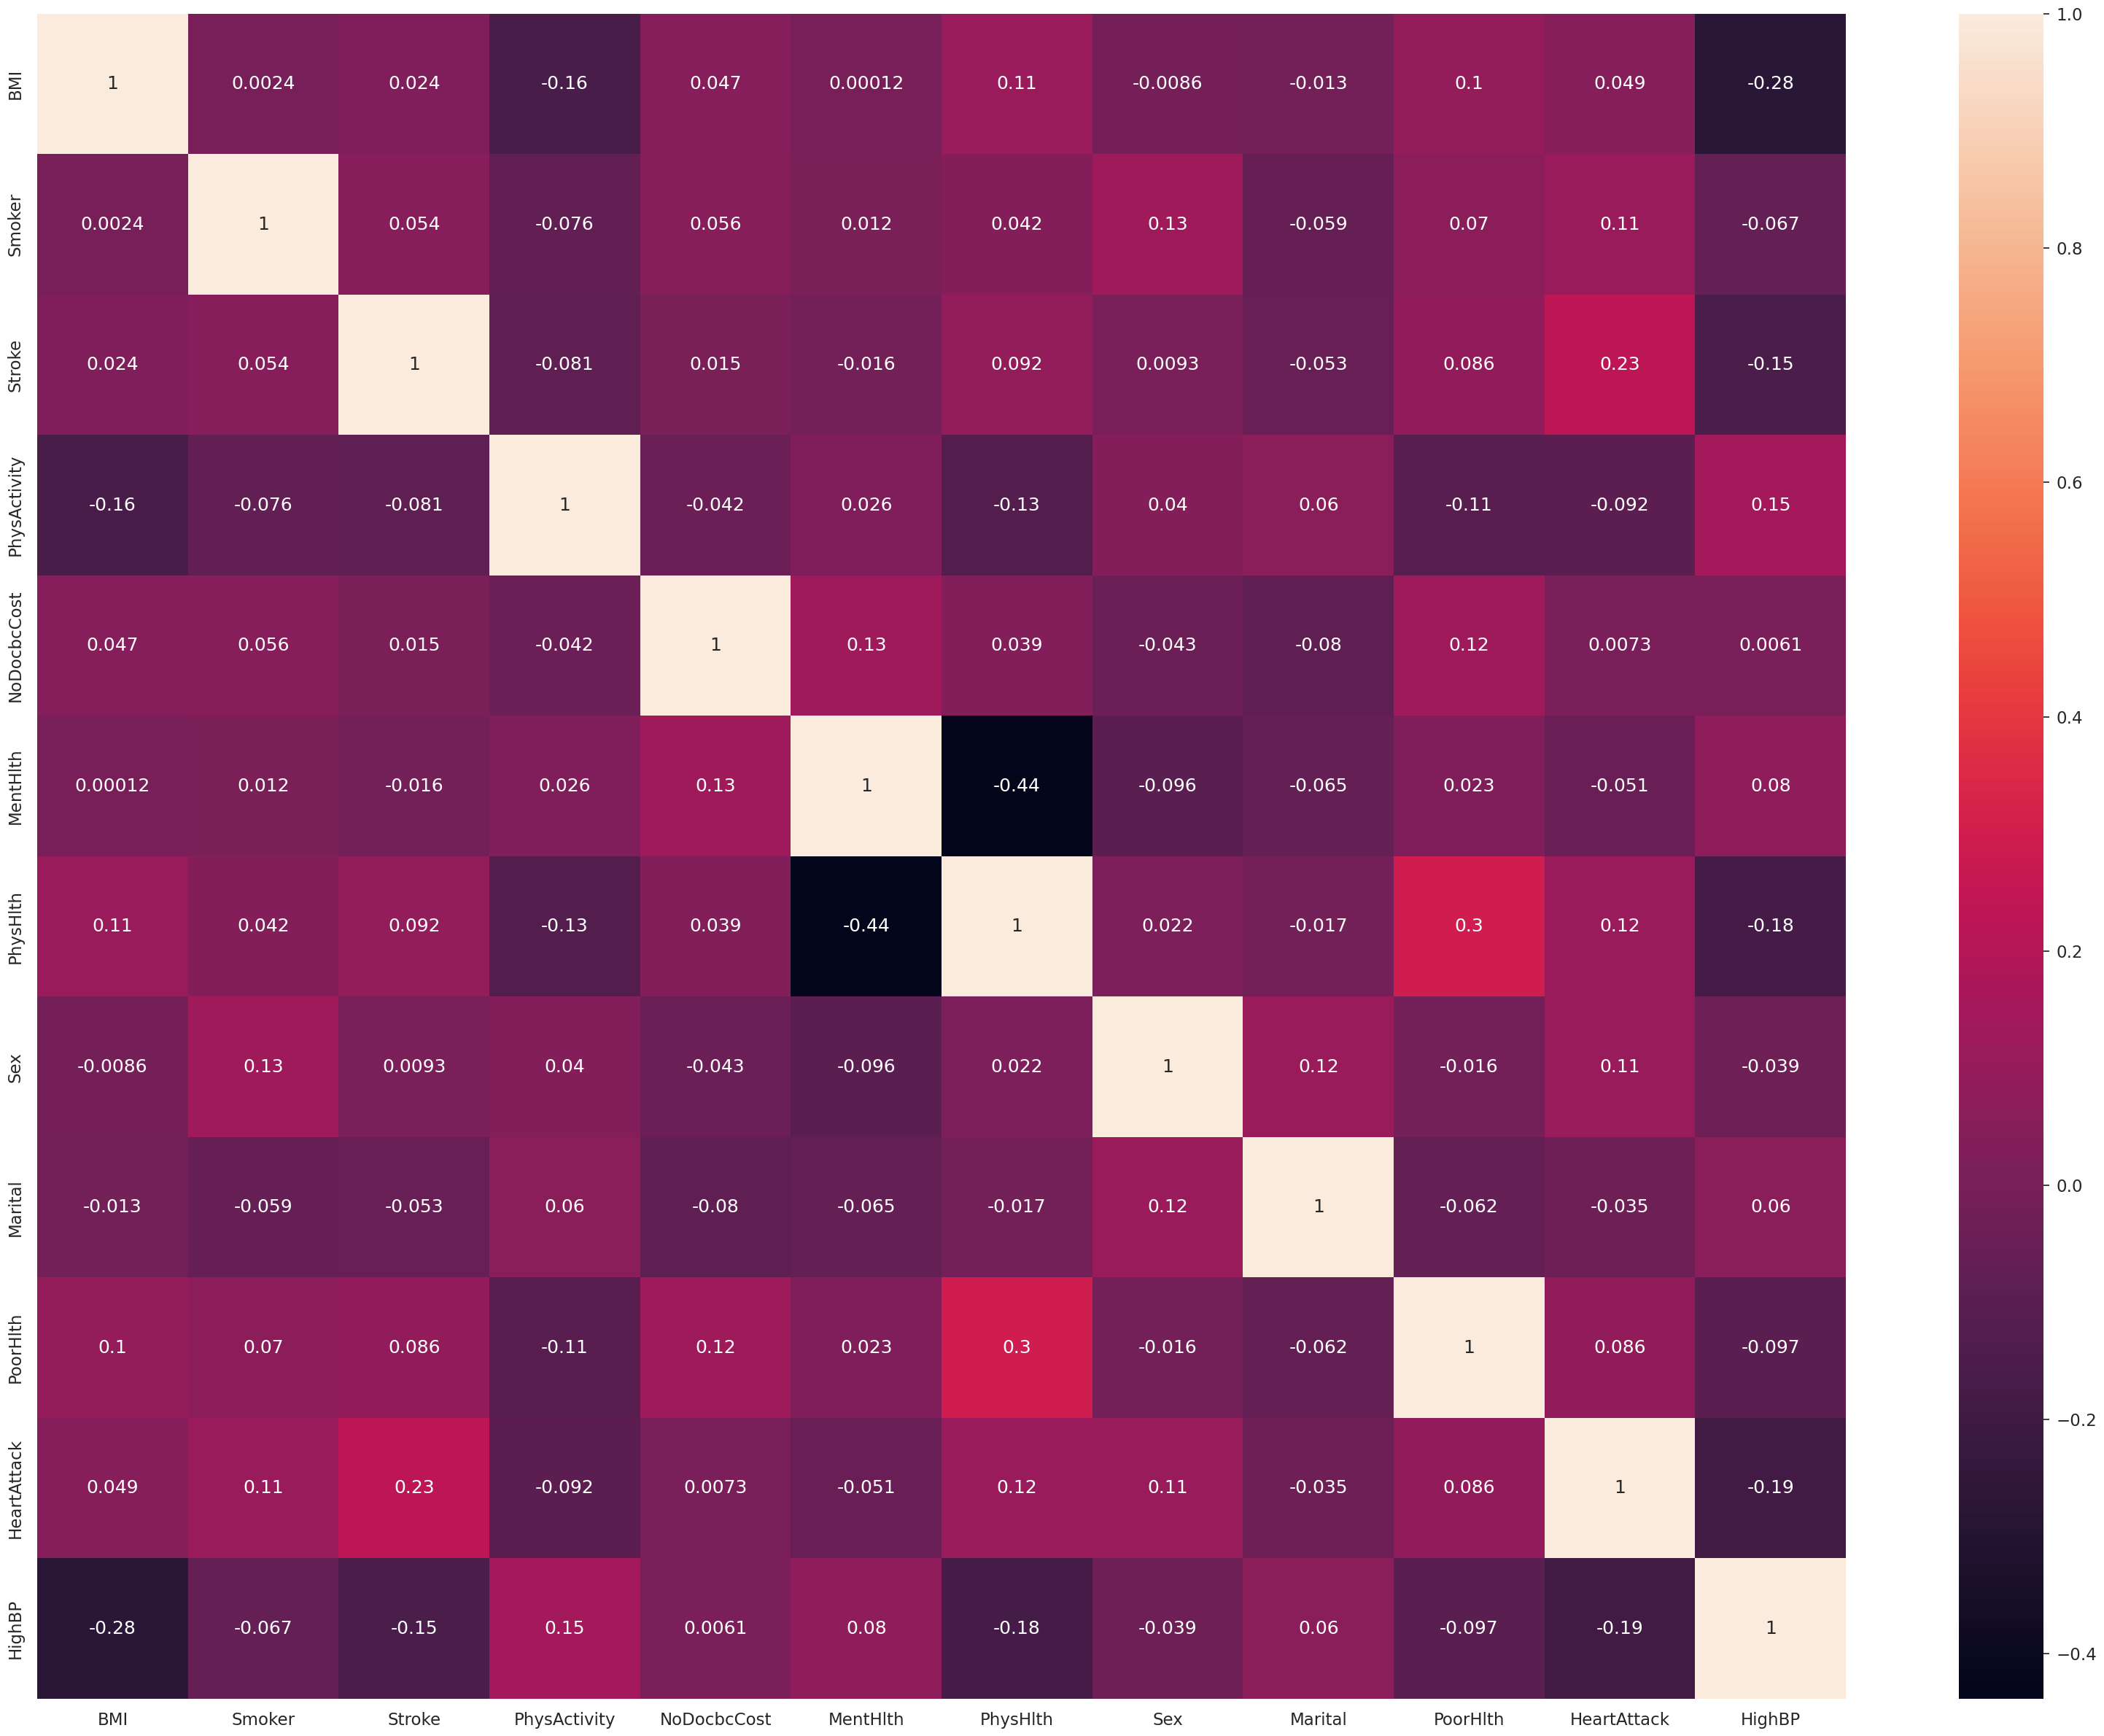

In [54]:
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are still features that are moderately correlated. We will eliminate one of the features for each correlated pair to reduce collinearity. 

In [55]:
data = data.drop(['PhysHlth'],axis=1)

## Create training and testing data sets

In [56]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)
print('Available Features',x.columns)
from sklearn.model_selection import train_test_split
x_tr_1, x_tst_1, y_tr_1, y_tst_1 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=0)

Available Features Index(['BMI', 'Smoker', 'Stroke', 'PhysActivity', 'NoDocbcCost', 'MentHlth',
       'Sex', 'Marital', 'PoorHlth', 'HeartAttack', 'HighBP'],
      dtype='object')


## Initial Multinomial Logistic Regression Models

### Statsmodels 

In [57]:
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.tools import add_constant
x_tr_1_const = add_constant(x_tr_1)
print(MNLogit(y_tr_1, x_tr_1_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.554056
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               117385
Model:                        MNLogit   Df Residuals:                   117373
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Aug 2023   Pseudo R-squ.:                  0.2007
Time:                        00:31:35   Log-Likelihood:                -65038.
converged:                       True   LL-Null:                       -81365.
Covariance Type:            nonrobust   LLR p-value:                     0.000
Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4711      0.025    -18.498      0.000      -0.521      -0.421
BMI              

We can see that our model is doing an ok job, but could be improved. 
All of our p-values indicate that our predictors are statistically significant and related to our outcome.

In [58]:
x_tr_2, x_tst_2, y_tr_2, y_tst_2 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=1)
x_tr_2_const = add_constant(x_tr_2)
print(MNLogit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.553135
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               117385
Model:                        MNLogit   Df Residuals:                   117373
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Aug 2023   Pseudo R-squ.:                  0.2020
Time:                        00:31:46   Log-Likelihood:                -64930.
converged:                       True   LL-Null:                       -81365.
Covariance Type:            nonrobust   LLR p-value:                     0.000
Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4882      0.025    -19.217      0.000      -0.538      -0.438
BMI              

Both models are performing about the same.
However, we have a lot of attributes, and will need to try other approaches and methods to see whether we can drop some of them or use other approaches to improve performance.


In [59]:
y_new = data['Diabetes_012']
x_new = data.drop('Diabetes_012',axis=1)

In [60]:
x_tr_sk, x_tst_sk, y_tr_sk, y_tst_sk = train_test_split(x_new,y_new,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [61]:
from sklearn.linear_model import LogisticRegression
mn_logit_1 = LogisticRegression(multi_class='multinomial',max_iter = 2500)
mn_logit_1.fit(x_tr_sk,y_tr_sk)
y_pred_mn1 = mn_logit_1.predict(x_tst_sk)
y_true_mn1 = y_tst_sk

Training accuracy:
0.72
Test accuracy:
0.72


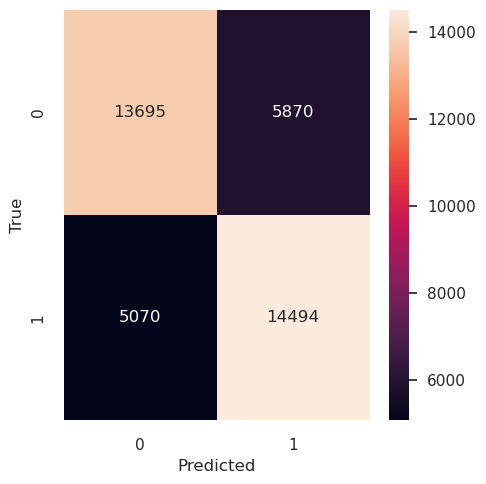

In [62]:
from sklearn.metrics import accuracy_score
print("Training accuracy:")
print(np.round(accuracy_score(y_tr_sk,mn_logit_1.predict(x_tr_sk)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_true_mn1,y_pred_mn1),2))

from sklearn.metrics import confusion_matrix
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_true_mn1,y_pred_mn1)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


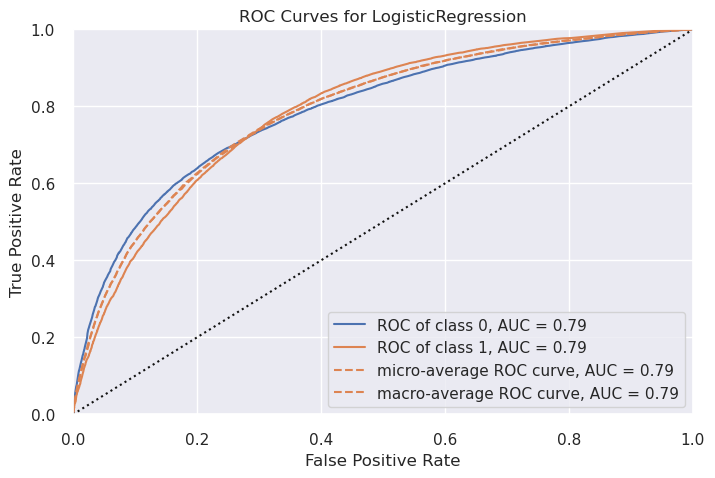

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
from yellowbrick.classifier import ROCAUC
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_1,classes=[0,1,2])
visualizer.fit(x_tr_sk, y_tr_sk)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

The model is performing similarly for both classes, but could be improved. 


What's happening here is that it is predicting the diabetes class, but is now performing a lot worse.

In [64]:
from sklearn.feature_selection import RFE
data.head
x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
mn_logit_rfe = LogisticRegression(multi_class="multinomial",max_iter=2500)
rfe = RFE(mn_logit_rfe)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [65]:
col = x.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

0              BMI
2           Stroke
3     PhysActivity
9      HeartAttack
10          HighBP
Name: Columns, dtype: object

In [66]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [67]:
model = MNLogit(train_y_rfe, new_train_x_rfe).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.559529
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               117385
Model:                        MNLogit   Df Residuals:                   117380
Method:                           MLE   Df Model:                            4
Date:                Mon, 07 Aug 2023   Pseudo R-squ.:                  0.1928
Time:                        00:32:37   Log-Likelihood:                -65680.
converged:                       True   LL-Null:                       -81365.
Covariance Type:            nonrobust   LLR p-value:                     0.000
Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
BMI                0.3652      0.004    100.383      0.000       0.358       0.372
Stroke           

In [70]:
mn_logit_rfe = LogisticRegression(multi_class='multinomial',max_iter = 2500)
mn_logit_rfe.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = mn_logit_rfe.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

Training accuracy:
0.72
Test accuracy:
0.72


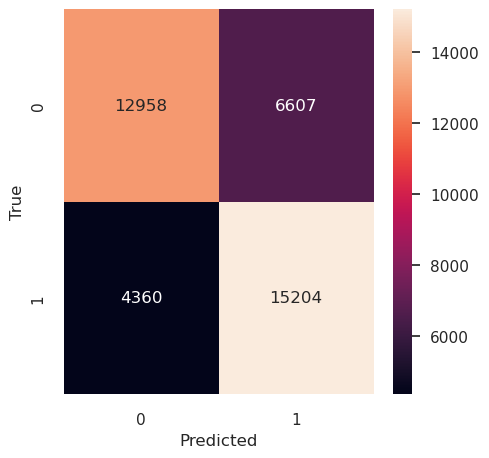

In [71]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,mn_logit_rfe.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


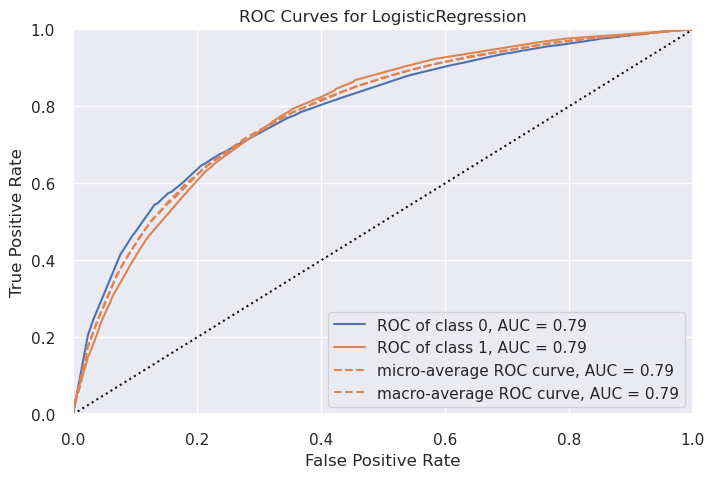

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [72]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_rfe,classes=[0,1,2])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

### Principal Component Analysis

In [73]:
from sklearn.preprocessing import StandardScaler

y_sc = data['Diabetes_012']
x_sc = data.drop('Diabetes_012',axis=1)

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_sc)


In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
pca.fit(x_tr)

PCA()

In [75]:
print('Variance Explained - %')
print(pca.explained_variance_ratio_ * 100)


Variance Explained - %
[15.66193866 12.00756368 10.45934465  9.49937287  8.66598186  8.32240026
  7.95789021  7.55399968  7.0564101   6.73585104  6.07924698]


Text(0, 0.5, 'explained variance')

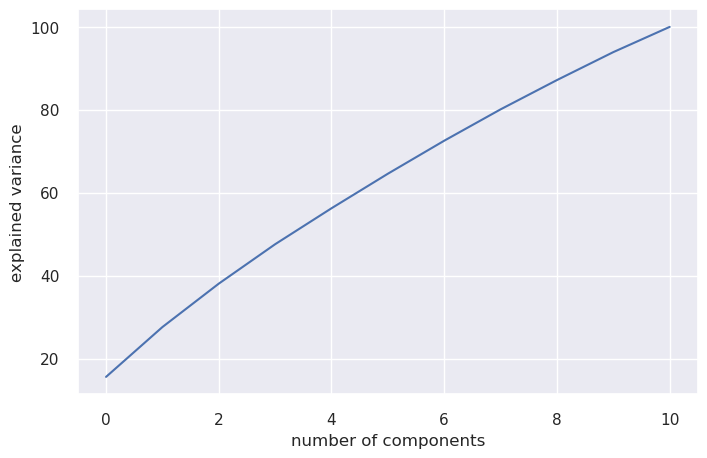

In [76]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('explained variance')

Unfortunately we can see that each of the included variables only explains a small portion of the variance in the outcome.